In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
import netCDF4 as nc
import h5py
import glob
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import integrate
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import os


CASE_CSV = "/Users/mcha4384/Desktop/CS Sahara/sahara_clearsky_case_2518.csv"
SSF_FILE = "/Users/mcha4384/Desktop/CS Sahara/ceres/CERES_SSF_NPP-XTRK_Edition2A_Subset_2024010100-2024010907.nc"

In [2]:
"""
CERES Point Spread Function - ATBD Table 4.4-2 Replication

This code reproduces the analytic CERES point spread function and footprint geometry described in ATBD v2.2, Section 4.4, and verifies the intermediate quantities listed in Table 4.4-2.
No gridding, resampling, or normalization is performed here. The goal is to confirm that the PSF shape, scan-direction asymmetry, and footprint extents match the ATBD before using the PSF in a full pipeline.

Following ATBD Section 4.4:
https://ceres.larc.nasa.gov/documents/ATBD/pdf/r2_2/ceres-atbd2.2-s4.4.pdf

"""
# ==============================================================================
# ATBD CONSTANTS
# ==============================================================================

class CeresConstants:
    """Physical constants from ATBD Section 4.4.1
    These constants are used in the PSF equation (4.4-1) and (4.4-2) and are fixed instrument values
    
    """
    a_deg = 0.65       # Half-width of FOV hexagon
    
    # Bolometer Time Response Coefficients (Eq 4.4-2)
    a1 = 1.84205
    a2 = -0.22502
    b1 = 1.47034
    b2 = 0.45904
    c1 = 1.98412
    
    k2_exp = 6.35465
    k2_freq = 1.90282
    k3_exp = 4.61598
    k3_freq = 5.83072

    # Earth & Satellite Geometry (Table 4.4-1: Orbital and FOV Characteristics)
    Re_km = 6367.0         # Earth Radius (per Table 4.4-1)
    h_km = 705.0           # Satellite Altitude (EOS/Terra, SNPP is 824 km, value changes with satellite)
    delta_shift_deg = 1.0 # (∆δ) Radiometric centroid shift applied to the along-scan direction before applying the PSF
                            # Note that δ' = δ + ∆δ, where δ' is evaluated in the PSF equation, and δ comes from the pixel coordinates (calculations shown later)

# ==============================================================================
# PSF CALCULATION
# ==============================================================================

def F_response(xi):
    """Detector time response function F(ξ). ATBD Equation 4.4-2.
    
    This function represents the integrated detector response to a 
    step input as a function of the dimensionless time variable ξ. Physically, 
    it describes how energy continues to be recorded after the detector has 
    passed over a point on the Earth due to finite thermal response time."""

    xi = np.asarray(xi)
    c = CeresConstants
    
    term1 = 1.0 - (1.0 + c.a1 + c.a2) * np.exp(-c.c1 * xi)
    term2 = np.exp(-c.k2_exp * xi) * (c.a1 * np.cos(c.k2_freq * xi) + 
                                      c.b1 * np.sin(c.k2_freq * xi))
    term3 = np.exp(-c.k3_exp * xi) * (c.a2 * np.cos(c.k3_freq * xi) + 
                                      c.b2 * np.sin(c.k3_freq * xi))
    
    return term1 + term2 + term3

def compute_psf_weight(delta_prime_deg, beta_deg):
    """Calculate Point Spread Function P(δ', β) in fixed angular space. ATBD Equation 4.4-1.
    Important note: Here, the PSF math itself only needs predetermined 𝛿' and β values. When using
    real data, geometric manipulation is required and is shown later in this pipeline.
    """
    c = CeresConstants
    
    delta = np.asarray(delta_prime_deg) + c.delta_shift_deg  # The along-scan coordinate δ′ is shifted by delta_shift_deg to align the PSF with the true radiometric centroid.
    beta_abs = np.abs(beta_deg)
    
    P = np.zeros_like(delta, dtype=float)
    valid_mask = beta_abs <= (2.0 * c.a_deg)
    
    if not np.any(valid_mask):
        return P
        
    d_valid = delta[valid_mask]
    b_valid = beta_abs[valid_mask]
    
    df = np.zeros_like(d_valid)
    db = np.zeros_like(d_valid)
    
    mask_inner = b_valid < c.a_deg
    mask_outer = ~mask_inner
    
    df[mask_inner] = -c.a_deg
    db[mask_inner] = c.a_deg
    
    df[mask_outer] = -2.0 * c.a_deg + b_valid[mask_outer]
    db[mask_outer] = 2.0 * c.a_deg - b_valid[mask_outer]
    
    P_vals = np.zeros_like(d_valid)
    
    mask_core = (d_valid >= df) & (d_valid < db)
    if np.any(mask_core):
        xi = d_valid[mask_core] - df[mask_core]
        P_vals[mask_core] = F_response(xi)
        
    mask_tail = (d_valid >= db)
    if np.any(mask_tail):
        xi_front = d_valid[mask_tail] - df[mask_tail]
        xi_back = d_valid[mask_tail] - db[mask_tail]
        P_vals[mask_tail] = F_response(xi_front) - F_response(xi_back)
            
    P[valid_mask] = P_vals
    return P

# ==============================================================================
# GEOMETRY FUNCTIONS
# ==============================================================================

"""
Geometry mapping between angular and ground coordinates.
This is not part of the PSF definition necessarily but is used here to reproduce Table 4.4-2, which reports 
ground distances corresponding to specific 𝛿' and β values.\\

Essentially, this section asks, “If I evaluate the PSF at the same angular offsets listed in Table 4.4-2, do I recover the same footprint sizes on the ground that the ATBD reports?”

The geometry functions below convert between:
cone angle α, viewing zenith angle θ, Earth central angle γ, ground distance l, and slant range ρ.

These relationships follow the spherical-Earth geometry implicit in ATBD Figure 4.4-2 and are used to translate angular PSF extents into physical footprint dimensions on the Earth's surface.
"""

def get_geometry_from_alpha(alpha_deg):
    """Derive Earth coordinates from cone angle α."""
    c = CeresConstants
    alpha_rad = np.radians(alpha_deg)
    
    sin_theta = np.sin(alpha_rad) * (c.Re_km + c.h_km) / c.Re_km
    theta_rad = np.arcsin(np.clip(sin_theta, -1.0, 1.0))
    
    gamma_rad = theta_rad - alpha_rad
    l_km = c.Re_km * gamma_rad
    
    term_cos = 2 * c.Re_km * (c.Re_km + c.h_km) * np.cos(gamma_rad)
    rho_sq = c.Re_km**2 + (c.Re_km + c.h_km)**2 - term_cos
    rho_km = np.sqrt(rho_sq)
    
    return {
        "alpha": alpha_deg,
        "theta": np.degrees(theta_rad),
        "gamma": np.degrees(gamma_rad),
        "l": l_km,
        "rho": rho_km,
    }

def get_alpha_from_theta(theta_deg):
    """Find cone angle α for desired viewing zenith θ."""
    c = CeresConstants
    theta_rad = np.radians(theta_deg)
    
    sin_alpha = np.sin(theta_rad) * c.Re_km / (c.Re_km + c.h_km)
    alpha_rad = np.arcsin(np.clip(sin_alpha, -1.0, 1.0))
    
    return np.degrees(alpha_rad)

# ==============================================================================
# TABLE 4.4-2 REPLICATION
# ==============================================================================

"""
The table converts angular cutoffs into ground distances for a few representative cases.
The 𝛿' and β values in the table are chosen inputs, not derived.

They correspond to: half-power cutoff and 95% energy cutoff. These cutoffs come from integrating the PSF, which the table assumes has already been done elsewhere.

The table then asks: “If I point the instrument at θ = 0°, 70°, 75°, what do these angular offsets look like on the ground?”
We are specifically looking at the EOS section of Table 4.4-2. More specifically, these are the representative case I chose to compare my PSF math to:
1. PSF half-power cutoff at nadir, α = 0°: Centroid at θ = 0°, α = 0.00°, γ = 0.00°
2. PSF 95% energy cutoff at nadir, α = 0°: Centroid at θ = 0°, α = 0.00°, γ = 0.00°
3. PSF 95% energy cutoff: Centroid at θ = 70°, α = 57.78°, γ = 12.22°
4. PSF 95% energy cutoff: Centroid at θ = 75°, α = 60.42°, γ = 14.58°

This section reproduces the footprint dimensions listed in ATBD Table 4.4-2.
Predefined angular offsets (𝛿', β), corresponding to half-power and 95% energy PSF cutoffs, are converted into ground distances using spherical Earth geometry.
Along-scan footprint extents are obtained by perturbing the instrument cone angle, while cross-scan extents are computed from the slant range and cross-scan angular offset.
These calculations are provided for validation and illustration only and do not modify the PSF definition.

# NOTE:
# Table 4.4-2 does not define the PSF. It only illustrates how selected angular PSF cutoffs map to ground distances.
"""


def print_table_row(name, delta, beta, alpha, theta, l, delta_l):
    """Print a single table row matching ATBD format."""
    if delta_l is not None:
        print(f"{name:<12} | {delta:6.2f} | {beta:6.2f} | "
              f"{theta:8.1f} | {l:10.1f} | {delta_l:10.0f}")
    else:
        print(f"{name:<12} | {delta:6.2f} | {beta:6.2f} | "
              f"{theta:8.1f} | {l:10.1f} |")

def calculate_footprint_table(target_theta_deg, points, use_signed_l=False):
    """    
    Args:
        target_theta_deg: Target viewing zenith angle
        points: List of (δ, β, name) tuples
        use_signed_l: If True, use signed l relative to centroid (for nadir)
                     If False, use absolute l from nadir (for high angles)
    """
    # Get centroid geometry
    alpha_cent = get_alpha_from_theta(target_theta_deg)
    cent_geo = get_geometry_from_alpha(alpha_cent)
    
    print(f"Centroid at θ = {target_theta_deg:.0f}°, "
          f"α = {cent_geo['alpha']:.2f}°, "
          f"γ = {cent_geo['gamma']:.2f}°")
    print("-" * 75)
    
    # Store values for footprint calculation
    l_back = None
    l_front = None
    l_cent = cent_geo['l']
    
    for delta, beta, name in points:
        if beta == 0:
            # Along-scan
            alpha_new = alpha_cent - delta
            if alpha_new < 0:
                alpha_new = abs(alpha_new)
            
            geo = get_geometry_from_alpha(alpha_new)
            
            # Calculate l for display
            if use_signed_l:
                # For nadir: show signed distance from centroid
                l_display = geo['l'] - l_cent
            else:
                # For high angles: show absolute distance from nadir
                l_display = geo['l']
            
            # Store for footprint calculation
            if delta < 0:
                l_back = abs(geo['l'] - l_cent)
            elif delta > 0:
                l_front = abs(geo['l'] - l_cent)
            
            # Δl: show full footprint for front edge, blank otherwise
            if name == "Front Edge" and l_back is not None:
                delta_l = l_back + l_front
            else:
                delta_l = None
            
            print_table_row(name, delta, beta, geo['alpha'], geo['theta'], 
                          l_display, delta_l)
            
        else:
            # Cross-scan
            rho = cent_geo['rho']
            beta_rad = np.radians(abs(beta))
            perp_dist = rho * np.tan(beta_rad)
            
            # Calculate θ for cross-scan properly
            # The point is at perpendicular distance perp_dist from scan line
            # at the centroid altitude/slant range location
            # True θ is viewing angle to this offset point
            
            # Method: The point is offset perpendicular by perp_dist
            # Total distance from satellite to point in 3D
            # Using Pythagorean theorem in the viewing geometry
            
            # At centroid: slant range is rho, looking at angle theta_cent
            # Cross-scan offset creates additional angular deviation
            # Total viewing angle: tan(θ_total) = perp_dist / (distance along viewing axis)
            
            # Better approach: Calculate actual α for the cross-scan point
            # The cross-scan offset changes the cone angle in 3D
            # Use: sin²(α_cross) = sin²(α_cent) + sin²(β)
            alpha_cent_rad = np.radians(cent_geo['alpha'])
            sin_alpha_cross = np.sqrt(np.sin(alpha_cent_rad)**2 + np.sin(beta_rad)**2)
            alpha_cross_rad = np.arcsin(np.clip(sin_alpha_cross, 0, 1))
            alpha_cross = np.degrees(alpha_cross_rad)
            
            # Now get θ from this α
            geo_cross = get_geometry_from_alpha(alpha_cross)
            theta_cross = geo_cross['theta']
            
            # Δl is full width
            delta_l = 2.0 * perp_dist
            
            print_table_row(name, delta, beta, cent_geo['alpha'], theta_cross,
                          perp_dist, delta_l)

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    print("\n" + "="*75)
    print("CERES PSF GEOMETRY - ATBD TABLE 4.4-2 REPLICATION: https://ceres.larc.nasa.gov/documents/ATBD/pdf/r2_2/ceres-atbd2.2-s4.4.pdf")
    print("="*75)
    
    # Table header
    header = (f"{'Point':<12} | {'δ':>6} | {'β':>6} | "
              f"{'θ':>8} | {'l':>10} | {'Δl':>10}")
    units = (f"{'':>12} | {'(°)':>6} | {'(°)':>6} | "
             f"{'(°)':>8} | {'(km)':>10} | {'(km)':>10}")
    
    # ===== NADIR CASES =====
    print("\n" + "="*75)
    print("PSF half-power cutoff at nadir, α = 0°")
    print("="*75)
    print(header)
    print(units)
    print("-" * 75)
    
    nadir_hp_points = [
        (-0.88, 0.0, "Back Edge"),
        (0.52, 0.0, "Front Edge"),
        (0.00, 1.08, "Cross Edge")
    ]
    calculate_footprint_table(0.0, nadir_hp_points, use_signed_l=True)
    
    print("\n" + "="*75)
    print("PSF 95% energy cutoff at nadir, α = 0°")
    print("="*75)
    print(header)
    print(units)
    print("-" * 75)
    
    nadir_95_points = [
        (-1.25, 0.0, "Back Edge"),
        (1.35, 0.0, "Front Edge"),
        (0.00, 1.27, "Cross Edge")
    ]
    calculate_footprint_table(0.0, nadir_95_points, use_signed_l=True)
    
    # ===== HIGH ANGLE CASES =====
    print("\n" + "="*75)
    print("PSF 95% energy cutoff")
    print("Centroid at θ = 70°, α = 57.78°, γ = 12.22°")
    print("="*75)
    print(header)
    print(units)
    print("-" * 75)
    
    vza70_points = [
        (-1.25, 0.0, "Back Edge"),
        (0.00, 0.0, "Centroid"),
        (1.35, 0.0, "Front Edge"),
        (0.00, 1.27, "Cross Edge")
    ]
    calculate_footprint_table(70.0, vza70_points, use_signed_l=False)
    
    print("\n" + "="*75)
    print("PSF 95% energy cutoff")
    print("Centroid at θ = 75°, α = 60.42°, γ = 14.58°")
    print("="*75)
    print(header)
    print(units)
    print("-" * 75)
    
    vza75_points = [
        (-1.25, 0.0, "Back Edge"),
        (0.00, 0.0, "Centroid"),
        (1.35, 0.0, "Front Edge"),
        (0.00, 1.27, "Cross Edge")
    ]
    calculate_footprint_table(75.0, vza75_points, use_signed_l=False)
    


CERES PSF GEOMETRY - ATBD TABLE 4.4-2 REPLICATION: https://ceres.larc.nasa.gov/documents/ATBD/pdf/r2_2/ceres-atbd2.2-s4.4.pdf

PSF half-power cutoff at nadir, α = 0°
Point        |      δ |      β |        θ |          l |         Δl
             |    (°) |    (°) |      (°) |       (km) |       (km)
---------------------------------------------------------------------------
Centroid at θ = 0°, α = 0.00°, γ = 0.00°
---------------------------------------------------------------------------
Back Edge    |  -0.88 |   0.00 |      1.0 |       10.8 |
Front Edge   |   0.52 |   0.00 |      0.6 |        6.4 |         17
Cross Edge   |   0.00 |   1.08 |      1.2 |       13.3 |         27

PSF 95% energy cutoff at nadir, α = 0°
Point        |      δ |      β |        θ |          l |         Δl
             |    (°) |    (°) |      (°) |       (km) |       (km)
---------------------------------------------------------------------------
Centroid at θ = 0°, α = 0.00°, γ = 0.00°
------------------

CERES PSF for VIIRS Pixel Weighting

Satellite: Terra
Altitude: 705 km
PSF grid: 601 × 601 pixels
Angular resolution: 0.010°
Centroid shift: 1.0°

VZA 0°
  [Table 4.4-1] Half-power at nadir:        17.2 km x 26.6 km
  PSF max: 0.000034

VZA 70°
  PSF max: 0.000034

VZA 75°
  [Table 4.4-1] Half-power at VZA=75:       182.1 km x 69.5 km
  [Table 4.4-1] 95%-energy at VZA=75:       368.6 km x 81.7 km
  PSF max: 0.000034



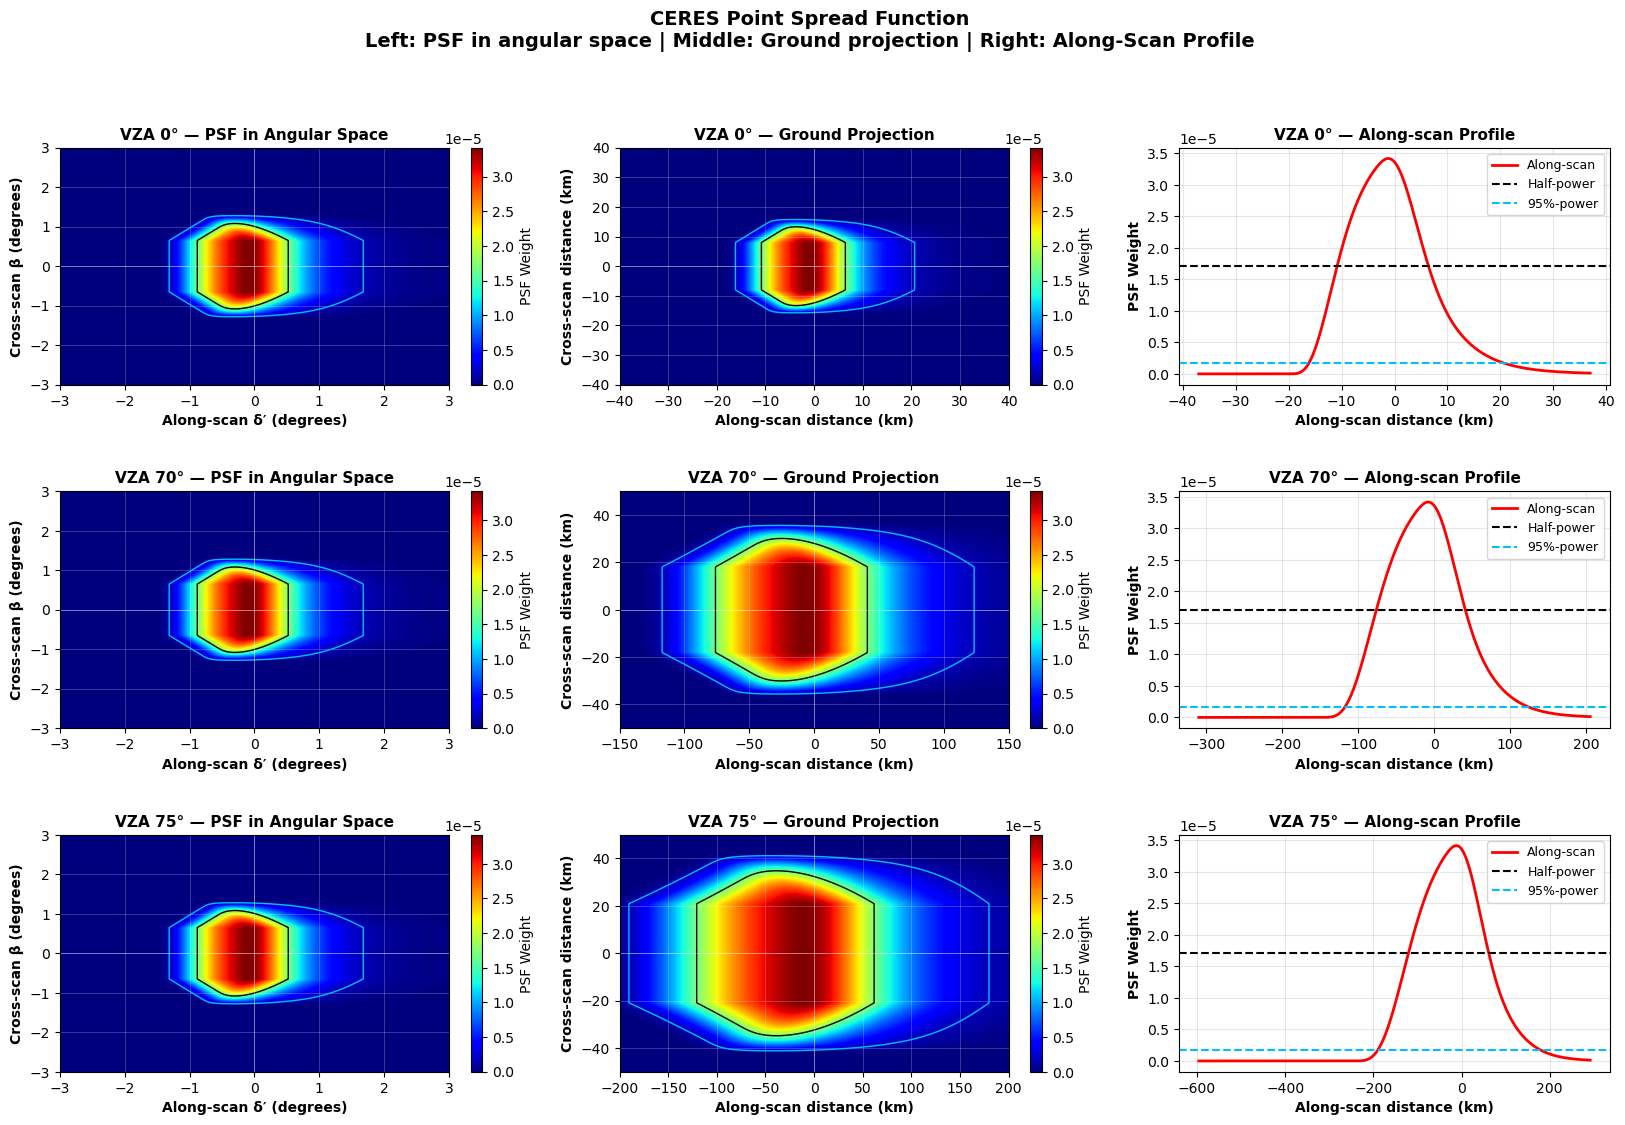

In [3]:
"""
VISUALIZATION — CERES PSF IN FIXED ANGULAR SPACE AND PROJECTED GROUND SPACE

For each VZA in [0°, 70°, 75°], produces three panels:
  1. The PSF in angular coordinates (δ′, β) — identical across
     VZAs since this is the instrument frame, not the ground frame
  2. The PSF projected onto the ground (km × km) using the ATBD
     spherical-Earth geometry — footprint grows and elongates
     along-scan as VZA increases toward limb
  3. A 1-D along-scan slice at β = 0 showing the asymmetric
     detector time-response tail

Contour levels match ATBD Table 4.4-1 thresholds:
  Black      → half-power  (50% of peak)
  DeepSkyBlue → 95%-energy (5% of peak)

Footprint dimensions are printed to stdout for the three cases
in Table 4.4-1: half-power at nadir, half-power at VZA=75,
and 95%-energy at VZA=75.

Footprint Sizes from Table 4.4-1:
PSF half-power cutoff. Centroid at nadir. 17 x 27 km
PSF 95% cutoff. Centroid at θ = 75º . 328 x 82 km
PSF half-power cutoff. Centroid at θ = 75º . 182 x 69 km


Note: This cell operates entirely in synthetic angular coordinates. 
The δ′ and β grids here are not derived  from real imager pixel positions. 
The geometric transformation that maps actual VIIRS pixel coordinates into the CERES instrument frame is not performed here. 
The ground projection here is therefore illustrative: it shows how the PSF footprint scales with 
VZA, but the (δ, β) offsets for any real pixel will need to be computed from its actual geometry before the PSF weight can be evaluated.
We are just checking some math to compare to the ATBD Table 4.4-1
"""

# ============================================================
# ATBD CONSTANTS
# ============================================================
a_deg = 0.65  # Half FOV width parameter
a1 = 1.84205
a2 = -0.22502
b1 = 1.47034
b2 = 0.45904
c1 = 1.98412

# ============================================================
# SATELLITE CONFIGURATION (from ATBD Table 4.4-1)
# ============================================================
SATELLITE_PARAMS = {
    "Terra": {"delta_shift_deg": 1.00, "alt_km": 705},
    "Aqua":  {"delta_shift_deg": 1.00, "alt_km": 705},
    "SNPP":  {"delta_shift_deg": 1.00, "alt_km": 824},
}

satellite = "Terra"
Re_km = 6367.0  # Earth radius EXACT per CERES ATBD §4.4.2
h_km = SATELLITE_PARAMS[satellite]["alt_km"]
delta_centroid_shift_deg = SATELLITE_PARAMS[satellite]["delta_shift_deg"]

# ============================================================
# ATBD FUNCTION F(ξ) - Equation 4.4-2
# ============================================================
def F_xi(xi):
    """ATBD time-response convolution function (Eq 4.4-2)"""
    xi = np.asarray(xi)
    term1 = 1.0 - (1.0 + a1 + a2) * np.exp(-c1 * xi)
    term2 = np.exp(-6.35465 * xi) * (a1 * np.cos(1.90282 * xi) + b1 * np.sin(1.90282 * xi))
    term3 = np.exp(-4.61598 * xi) * (a2 * np.cos(5.83072 * xi) + b2 * np.sin(5.83072 * xi))
    return term1 + term2 + term3

# ============================================================
# PSF CALCULATION - Equation 4.4-1
# ============================================================
def P_psf(delta_prime, beta, delta_shift):
    """CERES Point Spread Function from ATBD Eq 4.4-1"""
    delta_p = np.asarray(delta_prime) + delta_shift
    beta_abs = np.abs(beta)
    
    P = np.zeros(np.broadcast(delta_p, beta_abs).shape, dtype=float)
    valid = beta_abs <= 2.0 * a_deg
    
    if not np.any(valid):
        return P
    
    delta_p = np.broadcast_to(delta_p, P.shape)
    beta_abs = np.broadcast_to(beta_abs, P.shape)
    
    df = np.zeros_like(P)
    db = np.zeros_like(P)
    
    m1 = valid & (beta_abs < a_deg)
    df[m1] = -a_deg
    db[m1] = a_deg
    
    m2 = valid & (beta_abs >= a_deg)
    df[m2] = -2.0 * a_deg + beta_abs[m2]
    db[m2] = 2.0 * a_deg - beta_abs[m2]
    
    m_core = valid & (delta_p >= df) & (delta_p < db)
    if np.any(m_core):
        xi = delta_p[m_core] - df[m_core]
        P[m_core] = F_xi(xi)
    
    m_tail = valid & (delta_p >= db)
    if np.any(m_tail):
        xi1 = delta_p[m_tail] - df[m_tail]
        xi2 = delta_p[m_tail] - db[m_tail]
        P[m_tail] = F_xi(xi1) - F_xi(xi2)
    
    return P

# ============================================================
# ATBD GEOMETRY FUNCTIONS (Section 4.4.2.2)
# ============================================================

def calculate_psf_point_geometry(delta_deg, beta_deg, theta_centroid_deg, h_km, rE_km):
    """
    Calculate geometry for a PSF point at offset (δ, β) from centroid.
    """
    # Convert centroid VZA → cone angle
    theta0 = np.radians(theta_centroid_deg)
    alpha0 = np.arcsin(rE_km * np.sin(theta0) / (rE_km + h_km))

    # Centroid Earth geometry
    gamma0 = theta0 - alpha0
    l0 = rE_km * gamma0
    rho0 = np.sqrt(
        rE_km**2 + (rE_km + h_km)**2
        - 2 * rE_km * (rE_km + h_km) * np.cos(gamma0)
    )

    # Along-scan offset applied to cone angle
    alpha = alpha0 - np.radians(delta_deg)

    # Forward geometry
    theta = np.arcsin((rE_km + h_km) * np.sin(alpha) / rE_km)
    gamma = theta - alpha
    l = rE_km * gamma

    delta_l_km = l - l0

    # Cross-scan: perpendicular distance
    beta_rad = np.radians(beta_deg)
    beta_l_km = rho0 * beta_rad

    return {
        'theta': np.degrees(theta),
        'alpha': np.degrees(alpha),
        'gamma': np.degrees(gamma),
        'l': l,
        'rho': rho0,
        'delta_l': delta_l_km,
        'beta_l': beta_l_km,
        'theta_cent': theta_centroid_deg,
        'alpha_cent': np.degrees(alpha0),
        'l_cent': l0,
        'rho_cent': rho0,
    }

def psf_offsets_to_ground(delta_deg, beta_deg, theta_centroid_deg, h_km, rE_km):
    """Convert PSF angular offsets to ground distances."""
    geom = calculate_psf_point_geometry(delta_deg, beta_deg, theta_centroid_deg, h_km, rE_km)
    return geom['delta_l'], geom['beta_l']

# ============================================================
# CREATE PSF GRID
# ============================================================

def create_psf_grid(resolution_deg=0.01, extent_deg=3.0):
    """Create the CERES PSF on a regular angular grid."""
    delta = np.arange(-extent_deg, extent_deg + resolution_deg, resolution_deg)
    beta = np.arange(-extent_deg, extent_deg + resolution_deg, resolution_deg)
    DELTA, BETA = np.meshgrid(delta, beta)
    
    PSF = P_psf(DELTA, BETA, delta_centroid_shift_deg)
    PSF = PSF / PSF.sum()
    
    return delta, beta, PSF, DELTA, BETA

# ============================================================
# VISUALIZATION FOR VIIRS WEIGHTING
# ============================================================

def plot_psf_for_weighting():
    """
    Show the PSF in both angular and ground space for different VZAs.
    This demonstrates what you'll use for VIIRS weighting.
    """
    
    # Create PSF grid (angular space)
    delta, beta, PSF, DELTA, BETA = create_psf_grid(resolution_deg=0.01)

    vzas = [0, 70, 75]

    # ------------------------------------------------------------------
    # Precompute shared ground-space limits so ALL plots are comparable
    # ------------------------------------------------------------------
    x_extents = []
    y_extents = []

    for vza in vzas:
        DELTA_km, BETA_km = psf_offsets_to_ground(DELTA, BETA, vza, h_km, Re_km)
        x_extents.append(np.abs(DELTA_km).max())
        y_extents.append(np.abs(BETA_km).max())

    x_lim = max(x_extents)
    y_lim = max(y_extents)

    # Power levels (constant across all figures)
    half_power = 0.5 * PSF.max()
    fov_power  = 0.05 * PSF.max()

    print("="*80)
    print("CERES PSF for VIIRS Pixel Weighting")
    print("="*80)
    print(f"\nSatellite: {satellite}")
    print(f"Altitude: {h_km} km")
    print(f"PSF grid: {PSF.shape[0]} × {PSF.shape[1]} pixels")
    print(f"Angular resolution: {delta[1] - delta[0]:.3f}°")
    print(f"Centroid shift: {delta_centroid_shift_deg}°\n")

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.45, wspace=0.3)

    for i, vza in enumerate(vzas):

        print(f"VZA {vza}°")

        # ============================================================
        # 1) ANGULAR SPACE PSF (δ′, β)
        # ============================================================
        ax1 = fig.add_subplot(gs[i, 0])

        im1 = ax1.imshow(
            PSF,
            extent=[delta[0], delta[-1], beta[0], beta[-1]],
            origin="lower",
            cmap="jet",
            aspect="auto"
        )

        ax1.contour(delta, beta, PSF, levels=[half_power],
                    colors="black", linewidths=1)
        ax1.contour(delta, beta, PSF, levels=[fov_power],
                    colors="deepskyblue", linewidths=1)

        ax1.set_xlabel("Along-scan δ′ (degrees)", fontsize=10, weight='bold')
        ax1.set_ylabel("Cross-scan β (degrees)", fontsize=10, weight='bold')
        ax1.set_title(f"VZA {vza}° — PSF in Angular Space", fontsize=11, weight='bold')
        ax1.axhline(0, color="white", lw=0.5, alpha=0.5)
        ax1.axvline(0, color="white", lw=0.5, alpha=0.5)
        ax1.grid(alpha=0.3, color='white', linewidth=0.5)

        plt.colorbar(im1, ax=ax1, fraction=0.046, label="PSF Weight")


        # ============================================================
        # 2) GROUND-PROJECTED PSF
        # ============================================================
        ax2 = fig.add_subplot(gs[i, 1])

        DELTA_km, BETA_km = psf_offsets_to_ground(DELTA, BETA, vza, h_km, Re_km)

        # Flip along-scan for display consistency
        X = -DELTA_km
        Y =  BETA_km
        Z = PSF

        # Flatten for interpolation
        points = np.column_stack((X.ravel(), Y.ravel()))
        values = Z.ravel()

        # Define a *regular* ground grid with appropriate limits per VZA
        nx = ny = 400
        
        # Set limits based on VZA
        if vza == 0:
            xg = np.linspace(-40, 40, nx)
            yg = np.linspace(-40, 40, ny)
        elif vza == 70:
            xg = np.linspace(-150, 150, nx)
            yg = np.linspace(-50, 50, ny)
        else:  # vza == 75
            xg = np.linspace(-200, 200, nx)
            yg = np.linspace(-50, 50, ny)
            
        Xg, Yg = np.meshgrid(xg, yg)

        # Interpolate PSF onto regular km grid
        Zg = griddata(
            points,
            values,
            (Xg, Yg),
            method="linear",
            fill_value=0.0
        )

        im2 = ax2.imshow(
            Zg,
            extent=[xg[0], xg[-1], yg[0], yg[-1]],
            origin="lower",
            cmap="jet",
            vmin=0,
            aspect="auto"
        )

        # Contours
        ax2.contour(Xg, Yg, Zg, levels=[half_power],
                    colors="black", linewidths=1)
        ax2.contour(Xg, Yg, Zg, levels=[fov_power],
                    colors="deepskyblue", linewidths=1)

        # Calculate footprint size
        mask = PSF > half_power
        if np.any(mask):
            delta_extent = X[mask].max() - X[mask].min()
            beta_extent = Y[mask].max() - Y[mask].min()
        else:
            delta_extent = 0
            beta_extent = 0

        ax2.set_xlabel("Along-scan distance (km)", fontsize=10, weight='bold')
        ax2.set_ylabel("Cross-scan distance (km)", fontsize=10, weight='bold')
        ax2.set_title(f"VZA {vza}° — Ground Projection",
                     fontsize=11, weight='bold')
        ax2.grid(alpha=0.3, color='white', linewidth=0.5)
        ax2.axhline(0, color='white', linewidth=0.5, alpha=0.5)
        ax2.axvline(0, color='white', linewidth=0.5, alpha=0.5)

        plt.colorbar(im2, ax=ax2, fraction=0.046, label="PSF Weight")

        # ============================================================
        # 3) ALONG-SCAN PROFILE
        # ============================================================
        ax3 = fig.add_subplot(gs[i, 2])

        center_idx = len(beta) // 2
        along_profile = PSF[center_idx, :]
        delta_km_1d, _ = psf_offsets_to_ground(delta, 0.0, vza, h_km, Re_km)

        ax3.plot(-delta_km_1d, along_profile, "r-", lw=2, label="Along-scan")
        ax3.axhline(half_power, color="black", ls="--", lw=1.5, label="Half-power")
        ax3.axhline(fov_power, color="deepskyblue", ls="--", lw=1.5, label="95%-power")

        ax3.set_xlabel("Along-scan distance (km)", fontsize=10, weight='bold')
        ax3.set_ylabel("PSF Weight", fontsize=10, weight='bold')
        ax3.set_title(f"VZA {vza}° — Along-scan Profile", fontsize=11, weight='bold')
        ax3.grid(alpha=0.3)
        ax3.legend(fontsize=9)

        # Table 4.4-1 cross-check prints
        fov_power_mask = PSF > fov_power
        fov_delta_extent = X[fov_power_mask].max() - X[fov_power_mask].min() if np.any(fov_power_mask) else 0
        fov_beta_extent  = Y[fov_power_mask].max() - Y[fov_power_mask].min() if np.any(fov_power_mask) else 0

        if vza == 0:
            print(f"  [Table 4.4-1] Half-power at nadir:        {delta_extent:.1f} km x {beta_extent:.1f} km")
        if vza == 75:
            print(f"  [Table 4.4-1] Half-power at VZA=75:       {delta_extent:.1f} km x {beta_extent:.1f} km")
            print(f"  [Table 4.4-1] 95%-energy at VZA=75:       {fov_delta_extent:.1f} km x {fov_beta_extent:.1f} km")
        print(f"  PSF max: {PSF.max():.6f}\n")

    plt.suptitle('CERES Point Spread Function\n' +
                'Left: PSF in angular space | Middle: Ground projection | Right: Along-Scan Profile',
                fontsize=14, weight='bold', y=0.995)
    
    return fig, delta, beta, PSF

# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    # Create visualization
    fig, delta, beta, PSF = plot_psf_for_weighting()
    
    plt.show()


COMPLETE CERES PSF FOOTPRINT SIMULATOR

Footprint:
  Lat: 18.7054°N
  Lon: 330.3554°E
  VZA: 2.72°
  Scan azimuth: 80.73°
CERES PSF FOOTPRINT - ATBD METHOD
Footprint: 18.7054°N, -29.6446°E
VZA: 2.72°
Scan azimuth: 80.73°

Step 1: PSF in angular space
  Grid: 501 × 501 = 251001 points
  Resolution: 0.01° = 36.0 arcsec
  Max weight: 0.865293

Step 2: Convert to ground distances using VZA=2.72°
  Keeping 99531 significant points

Step 3: Map to Earth coordinates
  Along-scan direction → Azimuth 80.7°

Step 4: Calculate footprint dimensions
  Half-power (50%):  20.0 km × 31.1 km
  95% energy:        37.6 km × 36.3 km

  ATBD Table 4.4-2 at nadir: ~17 × 27 km (50%), ~32 × 31 km (95%)



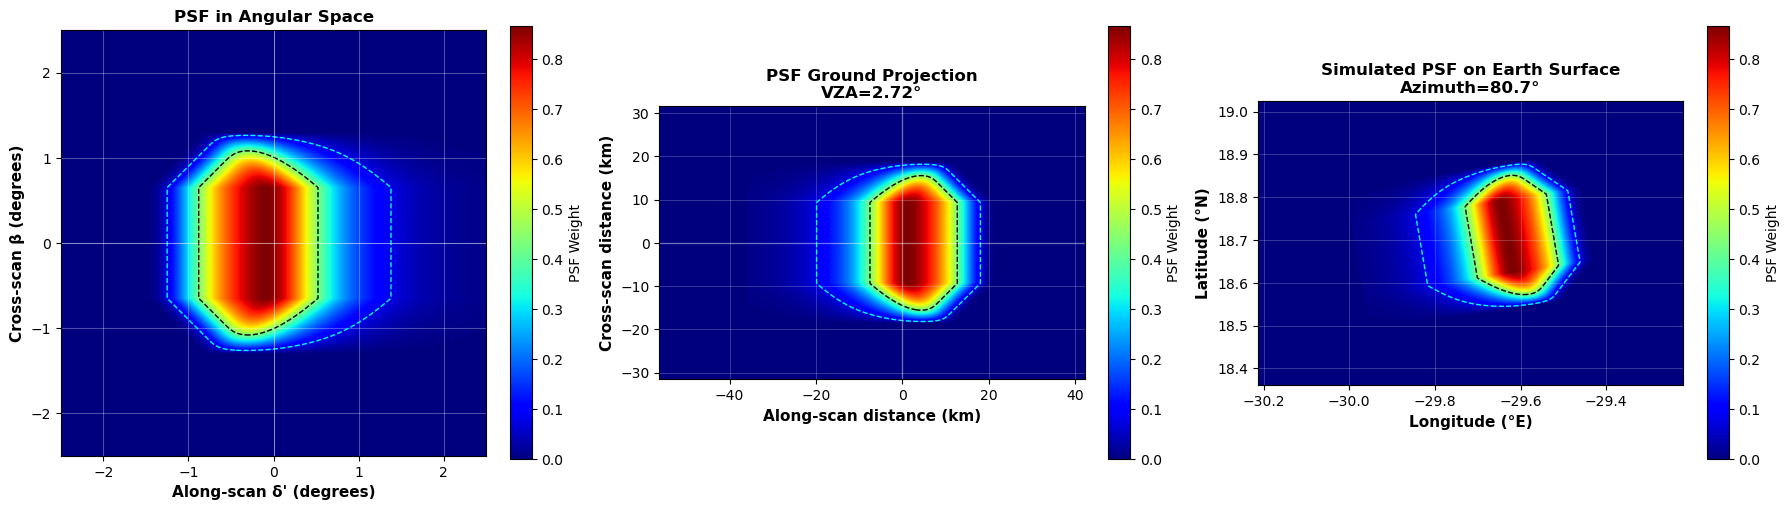


SUMMARY
VZA: 2.72°
Scan azimuth: 80.73°

Footprint dimensions:
  50% half-power: 20.0 km (along) × 31.1 km (cross)
  95% energy:     37.6 km (along) × 36.3 km (cross)

Expected at nadir for Terra (ATBD Table 4.4-2):
  50%: ~17 × 27 km
  95%: ~32 × 31 km

Grid points: 99531


In [ ]:
"""
CERES PSF FOOTPRINT SIMULATOR — USING REAL CERES DATA

Loads a real CERES footprint from the SSF product and simulates
its PSF projected onto the Earth's surface. Unlike the synthetic
visualization cell, this uses actual footprint geometry: the VZA
comes from the SSF record, and the scan azimuth is derived from
consecutive footprint positions in the SSF file.

Pipeline:
  1. Load footprint metadata (lat, lon, VZA) from case study CSV (CERES SSF Level-2)
  2. Compute scan azimuth from neighboring SSF footprint positions
  3. Build PSF on a uniform angular grid (ATBD Eq. 4.4-1, 4.4-2)
  4. Project each (δ, β) point to ground distances (km) using the
     ATBD spherical-Earth geometry (Section 4.4.2.2)
  5. Rotate from the scan frame into North/East, then convert to
     lat/lon using a local flat-Earth approximation
  6. Report half-power and 95%-energy footprint dimensions for
     comparison against ATBD Table 4.4-1

Output is a dict containing the PSF-weighted ground grid, contour
thresholds, and metadata — passed directly to plot_footprint_3panel().


Key notes:
  - Thresholds are evaluated at the ATBD Table 4.4-2 back boundary
    points (-0.88° and -1.25° at β=0) rather than as fractions of
    the PSF peak. This matches the ATBD contour definitions directly.
  - The cross-scan ground distance uses the small-angle approximation
    ρ x β_rad, consistent with the ATBD arc-length formulation and
    valid for |β| ≤ 1.3°.
  - Scan azimuth is a finite-difference approximation from neighboring
    footprint positions. The ATBD claims that the SSF also records α̇ (cone angle rate)
    directly, which would give a more precise instantaneous direction, 
    but I have not found that in my SSF L2 data.
  - The lat/lon conversion uses a local flat-Earth approximation
    (111 km/°). This is adequate for footprint-scale distances (~100 km
    at most) but will accumulate error at very high VZA.
  - The δ and β grids are still synthetic uniform arrays, not derived 
    from real VIIRS pixel coordinates. The PSF weights are therefore illustrative 
    of the footprint shape and dimensions, but the per-pixel weighting step — which requires
    computing the actual (δ, β) of each VIIRS pixel— is not yet performed here.

"""

# ==============================================================================
# CERES CONSTANTS (from ATBD Section 4.4.2 and Table 4.4-1)
# ==============================================================================

class CeresConstants:
    """Physical constants from ATBD Section 4.4.2 and Table 4.4-1"""
    a_deg = 0.65       # Half-width of FOV hexagon
    
    # Bolometer Time Response Coefficients (Eq 4.4-2)
    a1 = 1.84205
    a2 = -0.22502
    b1 = 1.47034
    b2 = 0.45904
    c1 = 1.98412
    
    k2_exp = 6.35465
    k2_freq = 1.90282
    k3_exp = 4.61598
    k3_freq = 5.83072

    # Earth & Satellite Geometry (Table 4.4-1)
    Re_km = 6367.0         # Earth Radius (ATBD value)
    h_km = 824.0           # Satellite Altitude for SNPP
    delta_shift_deg = 1.00 # Radiometric centroid shift for SNPP (at least from what I have found)
    
    # NOTE: For Terra/Aqua use h_km = 705.0

# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def normalize_longitude(lon):
    """Convert longitude from 0-360 to -180 to 180 format."""
    lon = np.asarray(lon)
    return np.where(lon > 180, lon - 360, lon)

# ==============================================================================
# PSF CALCULATION (EXACT ATBD Equations 4.4-1 and 4.4-2)
# ==============================================================================

def F_response(xi):
    """Detector time response function F(ξ). ATBD Equation 4.4-2."""
    xi = np.asarray(xi)
    c = CeresConstants
    
    term1 = 1.0 - (1.0 + c.a1 + c.a2) * np.exp(-c.c1 * xi)
    term2 = np.exp(-c.k2_exp * xi) * (c.a1 * np.cos(c.k2_freq * xi) + 
                                      c.b1 * np.sin(c.k2_freq * xi))
    term3 = np.exp(-c.k3_exp * xi) * (c.a2 * np.cos(c.k3_freq * xi) + 
                                      c.b2 * np.sin(c.k3_freq * xi))
    
    return term1 + term2 + term3

def compute_psf_weight(delta_prime, beta, delta_shift=None):
    """
    CERES Point Spread Function from ATBD Eq 4.4-1.
    
    Parameters
    ----------
    delta_prime : array_like
        Along-scan angular offset (degrees)
    beta : array_like
        Cross-scan angular offset (degrees)
    delta_shift : float, optional
        Radiometric centroid shift (default: use CeresConstants.delta_shift_deg)
    
    Returns
    -------
    P : ndarray
        PSF weights (0 to ~1, normalized to peak)
    """
    if delta_shift is None:
        delta_shift = CeresConstants.delta_shift_deg
    
    c = CeresConstants
    delta_p = np.asarray(delta_prime) + delta_shift
    beta_abs = np.abs(beta)

    # Initialize PSF array
    P = np.zeros(np.broadcast(delta_p, beta_abs).shape, dtype=float)

    # Valid beta region
    valid = beta_abs <= 2.0 * c.a_deg
    if not np.any(valid):
        return P

    # Broadcast arrays
    delta_p = np.broadcast_to(delta_p, P.shape)
    beta_abs = np.broadcast_to(beta_abs, P.shape)

    # Compute along-scan limits
    df = np.zeros_like(P)
    db = np.zeros_like(P)

    # Core (beta < a_deg)
    m_core_beta = valid & (beta_abs < c.a_deg)
    df[m_core_beta] = -c.a_deg
    db[m_core_beta] =  c.a_deg

    # Tail (beta >= a_deg)
    m_tail_beta = valid & (beta_abs >= c.a_deg)
    df[m_tail_beta] = -2.0 * c.a_deg + beta_abs[m_tail_beta]
    db[m_tail_beta] =  2.0 * c.a_deg - beta_abs[m_tail_beta]

    # Core PSF (δ′ inside df..db)
    m_core = valid & (delta_p >= df) & (delta_p < db)
    if np.any(m_core):
        xi = delta_p[m_core] - df[m_core]
        P[m_core] = F_response(xi)

    # Tail PSF (δ′ >= db)
    m_tail = valid & (delta_p >= db)
    if np.any(m_tail):
        xi1 = delta_p[m_tail] - df[m_tail]
        xi2 = delta_p[m_tail] - db[m_tail]
        P[m_tail] = F_response(xi1) - F_response(xi2)

    return P

# ==============================================================================
# GEOMETRY FUNCTIONS (EXACT ATBD Section 4.4.2.2)
# ==============================================================================

def get_alpha_from_theta(theta_deg, h_km=None, Re_km=None):
    """Find cone angle α for desired viewing zenith θ."""
    if h_km is None:
        h_km = CeresConstants.h_km
    if Re_km is None:
        Re_km = CeresConstants.Re_km
    
    theta_rad = np.radians(theta_deg)
    sin_alpha = np.sin(theta_rad) * Re_km / (Re_km + h_km)
    alpha_rad = np.arcsin(np.clip(sin_alpha, -1.0, 1.0))
    
    return np.degrees(alpha_rad)

def get_geometry_from_alpha(alpha_deg, h_km=None, Re_km=None):
    """Derive Earth coordinates from cone angle α."""
    if h_km is None:
        h_km = CeresConstants.h_km
    if Re_km is None:
        Re_km = CeresConstants.Re_km
    
    alpha_rad = np.radians(alpha_deg)
    
    sin_theta = np.sin(alpha_rad) * (Re_km + h_km) / Re_km
    theta_rad = np.arcsin(np.clip(sin_theta, -1.0, 1.0))
    
    gamma_rad = theta_rad - alpha_rad
    l_km = Re_km * gamma_rad
    
    term_cos = 2 * Re_km * (Re_km + h_km) * np.cos(gamma_rad)
    rho_sq = Re_km**2 + (Re_km + h_km)**2 - term_cos
    rho_km = np.sqrt(rho_sq)
    
    return {
        "alpha": alpha_deg,
        "theta": np.degrees(theta_rad),
        "gamma": np.degrees(gamma_rad),
        "l": l_km,
        "rho": rho_km,
    }

def psf_to_ground_distance(delta_deg, beta_deg, vza_deg):
    """
    Convert PSF angular offsets (δ, β) to ground distances (km).
    
    From ATBD Section 4.4.2.2 and Table 4.4-2:
    - Along-scan (δ): Apply to cone angle α, get arc length on Earth
    - Cross-scan (β): Perpendicular distance = ρ × β_rad (small-angle, consistent
      with ATBD which uses arc-length approximation for |β| <= 1.3°)
    
    Parameters
    ----------
    delta_deg : array_like
        Along-scan angular offset (degrees)
    beta_deg : array_like
        Cross-scan angular offset (degrees)  
    vza_deg : float
        Viewing zenith angle (degrees)
    
    Returns
    -------
    tuple : (along_scan_km, cross_scan_km)
    """
    # Get centroid geometry from VZA
    alpha_cent = get_alpha_from_theta(vza_deg)
    cent_geo = get_geometry_from_alpha(alpha_cent)
    
    # Along-scan: Change cone angle by delta, compute arc length difference
    alpha_point = alpha_cent - np.asarray(delta_deg)
    point_geo = get_geometry_from_alpha(alpha_point)
    along_scan_km = point_geo['l'] - cent_geo['l']
    
    # Cross-scan: small-angle arc length at slant range (ATBD §4.4.2.2)
    # Using beta_rad rather than tan(beta_rad) — difference is <0.01% for
    # |β| <= 1.3° but keeps this consistent with the ATBD arc-length formulation
    beta_rad = np.radians(np.asarray(beta_deg))
    cross_scan_km = cent_geo['rho'] * beta_rad
    
    return along_scan_km, cross_scan_km

# ==============================================================================
# SCAN AZIMUTH FROM SSF
# ==============================================================================

def compute_scan_azimuth_from_ssf(ssf, center_idx, half_window=5):
    """
    Compute scan azimuth from consecutive footprints in SSF file.

    This is a finite-difference approximation of the scan direction derived
    from neighboring footprint positions. The ATBD claims that the  SSF also 
    records the cone angle rate α̇ directly (although I did not find this, thus it is not used), 
    which gives the instantaneous scan direction more precisely — consider using that when higher accuracy is needed.
    
    Parameters
    ----------
    ssf : netCDF4.Dataset
        Opened SSF Level 2 file
    center_idx : int
        Index of the center footprint in SSF
    half_window : int
        Number of footprints before/after center
    
    Returns
    -------
    scan_azimuth_deg : float
        Scan azimuth in degrees (0°=N, 90°=E, clockwise from North)
    """
    i0 = max(center_idx - half_window, 0)
    i1 = center_idx + half_window + 1

    lat = ssf.groups['Time_and_Position'].variables['instrument_fov_latitude'][i0:i1]
    lon = ssf.groups['Time_and_Position'].variables['instrument_fov_longitude'][i0:i1]
    lon = normalize_longitude(lon)

    # Scan direction vector (first → last in time)
    dlat = lat[-1] - lat[0]  # North component
    dlon = lon[-1] - lon[0]  # East component

    # Azimuth angle
    azimuth = np.degrees(np.arctan2(dlon, dlat))
    if azimuth < 0:
        azimuth += 360

    return azimuth

# ==============================================================================
# MAIN FOOTPRINT GENERATION
# ==============================================================================

def generate_ceres_footprint(footprint_row, scan_azimuth_deg, 
                             psf_resolution_deg=0.01, psf_extent_deg=2.5):
    """
    Generate CERES PSF footprint on Earth.
    
    The CERES process:
    1. Define PSF P(δ', β) in angular space (ATBD Eq 4.4-1)
    2. For this footprint's VZA, convert each (δ', β) to ground distances
    3. PSF is in scan frame: δ = along-scan, β = cross-scan
    4. Map to Earth using scan azimuth
    
    Parameters
    ----------
    footprint_row : pandas.Series
        Row with SSF variables (must have VZA, lat, lon)
    scan_azimuth_deg : float
        Direction of satellite motion on Earth (0°=N, 90°=E)
    psf_resolution_deg : float
        Grid resolution in angular space
    psf_extent_deg : float
        Extent of PSF grid in degrees
    
    Returns
    -------
    dict
        Contains grid, contours, center, metadata, psf_grid
    """
    vza = float(footprint_row['view_zenith_angle'])
    fov_lat = float(footprint_row['instrument_fov_latitude'])
    fov_lon = normalize_longitude(float(footprint_row['instrument_fov_longitude']))
    
    print("="*80)
    print("CERES PSF FOOTPRINT - ATBD METHOD")
    print("="*80)
    print(f"Footprint: {fov_lat:.4f}°N, {fov_lon:.4f}°E")
    print(f"VZA: {vza:.2f}°")
    print(f"Scan azimuth: {scan_azimuth_deg:.2f}°")
    
    # Step 1: Create PSF in angular space (δ', β)
    delta_vals = np.arange(-psf_extent_deg, psf_extent_deg + psf_resolution_deg, 
                           psf_resolution_deg)
    beta_vals = np.arange(-psf_extent_deg, psf_extent_deg + psf_resolution_deg, 
                          psf_resolution_deg)
    
    DELTA, BETA = np.meshgrid(delta_vals, beta_vals)
    PSF = compute_psf_weight(DELTA, BETA)
    
    print(f"\nStep 1: PSF in angular space")
    print(f"  Grid: {len(delta_vals)} × {len(beta_vals)} = {DELTA.size} points")
    print(f"  Resolution: {psf_resolution_deg}° = {psf_resolution_deg * 3600:.1f} arcsec")
    print(f"  Max weight: {PSF.max():.6f}")
    
    # Step 2: Convert to ground distances
    print(f"\nStep 2: Convert to ground distances using VZA={vza:.2f}°")
    
    significant_mask = PSF > 0.001 * PSF.max()
    delta_flat = DELTA[significant_mask]
    beta_flat = BETA[significant_mask]
    psf_flat = PSF[significant_mask]
    
    print(f"  Keeping {len(psf_flat)} significant points")
    
    # Vectorized conversion — psf_to_ground_distance accepts arrays directly
    along_scan_km, cross_scan_km = psf_to_ground_distance(delta_flat, beta_flat, vza)
    
    # Step 3: Map to Earth coordinates
    print(f"\nStep 3: Map to Earth coordinates")
    print(f"  Along-scan direction → Azimuth {scan_azimuth_deg:.1f}°")
    
    azimuth_rad = np.radians(scan_azimuth_deg)
    
    # Convert from scan frame to North/East frame
    north_km = along_scan_km * np.cos(azimuth_rad) - cross_scan_km * np.sin(azimuth_rad)
    east_km = along_scan_km * np.sin(azimuth_rad) + cross_scan_km * np.cos(azimuth_rad)
    
    # Convert to lat/lon
    km_per_deg_lat = 111.0
    km_per_deg_lon = 111.0 * np.cos(np.radians(fov_lat))
    
    lat_points = fov_lat + north_km / km_per_deg_lat
    lon_points = fov_lon + east_km / km_per_deg_lon
    
    # Create output DataFrame
    grid_df = pd.DataFrame({
        'lat': lat_points,
        'lon': lon_points,
        'psf_weight': psf_flat,
        'delta_deg': delta_flat,
        'beta_deg': beta_flat,
        'along_scan_km': along_scan_km,
        'cross_scan_km': cross_scan_km,
        'north_km': north_km,
        'east_km': east_km
    })
    
    psf_max   = PSF.max()
    half_power = compute_psf_weight(np.array([-0.88]), np.array([0.0]))[0]
    energy_95  = compute_psf_weight(np.array([-1.25]), np.array([0.0]))[0]
    
    print(f"\nStep 4: Calculate footprint dimensions")
    
    def get_dims(grid_df, threshold):
        mask = grid_df['psf_weight'] >= threshold
        if mask.sum() < 3:
            return None, None
        points = grid_df[mask]
        along = points['along_scan_km'].max() - points['along_scan_km'].min()
        cross = points['cross_scan_km'].max() - points['cross_scan_km'].min()
        return along, cross
    
    hp_along, hp_cross = get_dims(grid_df, half_power)
    e95_along, e95_cross = get_dims(grid_df, energy_95)
    
    print(f"  Half-power (50%):  {hp_along:.1f} km × {hp_cross:.1f} km")
    print(f"  95% energy:        {e95_along:.1f} km × {e95_cross:.1f} km")
    print(f"\n  ATBD Table 4.4-2 at nadir: ~17 × 27 km (50%), ~32 × 31 km (95%)")
    
    contours = {
        'psf_max': psf_max,
        'half_power': half_power,
        'energy_95': energy_95,
        'half_power_dims': {'along_scan_km': hp_along, 'cross_scan_km': hp_cross},
        'energy_95_dims': {'along_scan_km': e95_along, 'cross_scan_km': e95_cross}
    }
    
    print("\n" + "="*80)
    
    return {
        'grid': grid_df,
        'contours': contours,
        'center': {'lat': fov_lat, 'lon': fov_lon},
        'metadata': {
            'vza': vza,
            'scan_azimuth': scan_azimuth_deg,
            'footprint_index': footprint_row.get('footprint_index', None),
            'center_index': footprint_row.get('center_index', None)
        },
        'psf_grid': {'delta': delta_vals, 'beta': beta_vals, 'PSF': PSF}
    }

# ==============================================================================
# VISUALIZATION
# ==============================================================================

def plot_footprint_3panel(footprint_data, figsize=(18, 6)):
    """Plot PSF in fixed angular space, projected onto Earth's surface, and projected onto Earth's surface with PSF rotation."""
    
    grid = footprint_data['grid']
    contours = footprint_data['contours']
    center = footprint_data['center']
    meta = footprint_data['metadata']
    psf_grid = footprint_data['psf_grid']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # ============================================================
    # Panel 1: Angular Space PSF (δ, β)
    # ============================================================
    ax1 = axes[0]
    
    delta = psf_grid['delta']
    beta = psf_grid['beta']
    PSF = psf_grid['PSF']
    
    im1 = ax1.imshow(PSF,
                    extent=[delta[0], delta[-1], beta[0], beta[-1]],
                    origin='lower', cmap='jet', aspect='auto')

    ax1.contour(delta, beta, PSF, levels=[contours['half_power']],
                colors='black', linewidths=1, linestyles='--')
    ax1.contour(delta, beta, PSF, levels=[contours['energy_95']],
                colors='cyan', linewidths=1, linestyles='--')
    
    ax1.axhline(0, color='white', linewidth=0.5, alpha=0.5)
    ax1.axvline(0, color='white', linewidth=0.5, alpha=0.5)
    ax1.set_xlim([-2.5, 2.5])
    ax1.set_ylim([-2.5, 2.5])
    
    ax1.set_xlabel('Along-scan δ\' (degrees)', fontsize=11, weight='bold')
    ax1.set_ylabel('Cross-scan β (degrees)', fontsize=11, weight='bold')
    ax1.set_title('PSF in Angular Space', fontsize=12, weight='bold')
    ax1.grid(alpha=0.3, color='white')
    ax1.set_aspect('equal')
    plt.colorbar(im1, ax=ax1, fraction=0.046, label='PSF Weight')
    
    # ============================================================
    # Panel 2: PSF Projected onto Earth's Surface
    # ============================================================
    ax2 = axes[1]
    
    X = grid['along_scan_km'].values
    Y = grid['cross_scan_km'].values
    Z = grid['psf_weight'].values
    
    points = np.column_stack((X, Y))
    
    # Create padded grid
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    x_pad = (x_max - x_min) * 0.35
    y_pad = (y_max - y_min) * 0.35
    
    xg = np.linspace(x_min - x_pad, x_max + x_pad, 400)
    yg = np.linspace(y_min - y_pad, y_max + y_pad, 400)
    Xg, Yg = np.meshgrid(xg, yg)
    
    Zg = griddata(points, Z, (Xg, Yg), method='linear', fill_value=0.0)
    
    im2 = ax2.imshow(Zg, extent=[xg[0], xg[-1], yg[0], yg[-1]],
                     origin='lower', cmap='jet', vmin=0, aspect='auto')
    
    ax2.contour(Xg, Yg, Zg, levels=[contours['half_power']], 
                colors='black', linewidths=1, linestyles='--')
    ax2.contour(Xg, Yg, Zg, levels=[contours['energy_95']], 
                colors='cyan', linewidths=1, linestyles='--')
    
    ax2.set_xlabel('Along-scan distance (km)', fontsize=11, weight='bold')
    ax2.set_ylabel('Cross-scan distance (km)', fontsize=11, weight='bold')
    ax2.set_title(f'PSF Ground Projection\nVZA={meta["vza"]:.2f}°', fontsize=12, weight='bold')
    ax2.grid(alpha=0.3, color='white', linewidth=0.5)
    ax2.set_aspect('equal')
    ax2.axhline(0, color='white', linewidth=1, alpha=0.3)
    ax2.axvline(0, color='white', linewidth=1, alpha=0.3)
    plt.colorbar(im2, ax=ax2, fraction=0.046, label='PSF Weight')
    
    # ============================================================
    # Panel 3: PSF Projected onto Earth's Surface with PSF Rotation
    # ============================================================
    ax3 = axes[2]
    
    points_geo = grid[['lon', 'lat']].values
    values_geo = grid['psf_weight'].values
    
    lat_min, lat_max = grid['lat'].min(), grid['lat'].max()
    lon_min, lon_max = grid['lon'].min(), grid['lon'].max()
    lat_pad = (lat_max - lat_min) * 0.35
    lon_pad = (lon_max - lon_min) * 0.35
    
    lat_grid = np.linspace(lat_min - lat_pad, lat_max + lat_pad, 400)
    lon_grid = np.linspace(lon_min - lon_pad, lon_max + lon_pad, 400)
    LON_GRID, LAT_GRID = np.meshgrid(lon_grid, lat_grid)
    
    PSF_geo = griddata(points_geo, values_geo, (LON_GRID, LAT_GRID), 
                      method='linear', fill_value=0.0)
    
    im3 = ax3.imshow(PSF_geo, extent=[lon_grid[0], lon_grid[-1], lat_grid[0], lat_grid[-1]],
                     origin='lower', cmap='jet', vmin=0, aspect='auto')
    
    ax3.contour(LON_GRID, LAT_GRID, PSF_geo, levels=[contours['half_power']], 
                colors='black', linewidths=1, linestyles='--')
    ax3.contour(LON_GRID, LAT_GRID, PSF_geo, levels=[contours['energy_95']], 
                colors='cyan', linewidths=1, linestyles='--')
    
    ax3.set_xlabel('Longitude (°E)', fontsize=11, weight='bold')
    ax3.set_ylabel('Latitude (°N)', fontsize=11, weight='bold')
    ax3.set_title(f'Simulated PSF on Earth Surface\nAzimuth={meta["scan_azimuth"]:.1f}°', 
                 fontsize=12, weight='bold')
    ax3.grid(alpha=0.3, color='white', linewidth=0.5)
    ax3.set_aspect('equal')
    plt.colorbar(im3, ax=ax3, fraction=0.046, label='PSF Weight')
    
    plt.tight_layout()
    return fig

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    
    # Configuration
    CASE_CSV = "/Users/mcha4384/Desktop/CS Sahara/sahara_clearsky_case_2518.csv"
    SSF_FILE = "/Users/mcha4384/Desktop/CS Sahara/ceres/CERES_SSF_NPP-XTRK_Edition2A_Subset_2024010100-2024010907.nc"
    
    print("\n" + "="*80)
    print("COMPLETE CERES PSF FOOTPRINT SIMULATOR")
    print("="*80)
    
    # Load case study
    df = pd.read_csv(CASE_CSV)
    if 'role' in df.columns:
        footprint_row = df[df['role'] == 'center'].iloc[0]
    else:
        footprint_row = df.iloc[0]
    
    print(f"\nFootprint:")
    print(f"  Lat: {footprint_row['instrument_fov_latitude']:.4f}°N")
    print(f"  Lon: {footprint_row['instrument_fov_longitude']:.4f}°E")
    print(f"  VZA: {footprint_row['view_zenith_angle']:.2f}°")
    
    # Get scan azimuth from SSF
    ssf = nc.Dataset(SSF_FILE, 'r')
    center_idx = int(footprint_row['center_index'])
    scan_azimuth = compute_scan_azimuth_from_ssf(ssf, center_idx, half_window=5)
    ssf.close()
    
    print(f"  Scan azimuth: {scan_azimuth:.2f}°")
    
    # Generate footprint
    footprint_data = generate_ceres_footprint(
        footprint_row, 
        scan_azimuth_deg=scan_azimuth,
        psf_resolution_deg=0.01,
        psf_extent_deg=2.5
    )
    
    # Visualize
    fig = plot_footprint_3panel(footprint_data)
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    print(f"VZA: {footprint_data['metadata']['vza']:.2f}°")
    print(f"Scan azimuth: {footprint_data['metadata']['scan_azimuth']:.2f}°")
    
    hp_dims = footprint_data['contours']['half_power_dims']
    e95_dims = footprint_data['contours']['energy_95_dims']
    
    print(f"\nFootprint dimensions:")
    print(f"  50% half-power: {hp_dims['along_scan_km']:.1f} km (along) × "
          f"{hp_dims['cross_scan_km']:.1f} km (cross)")
    print(f"  95% energy:     {e95_dims['along_scan_km']:.1f} km (along) × "
          f"{e95_dims['cross_scan_km']:.1f} km (cross)")
    
    print(f"\nExpected at nadir for Terra (ATBD Table 4.4-2):")
    print(f"  50%: ~17 × 27 km")
    print(f"  95%: ~32 × 31 km")
    
    print(f"\nGrid points: {len(footprint_data['grid'])}")
    print("="*80)

In [5]:
"""
BUILD SATELLITE AXIS SYSTEM — ATBD Equations 4.4-3 through 4.4-7

Constructs the satellite-centered coordinate frame (X̂', Ŷ', Ẑ')
needed to compute the (δ, β) angular offsets of any imager pixel
relative to the CERES footprint centroid. This is a prerequisite
for evaluating the PSF weight at each VIIRS pixel in the next step.

The three axes are defined at the satellite as follows:
  Ŷ' — points from the satellite toward the footprint centroid
         on the Earth's surface (Eq 4.4-6)
  X̂' — perpendicular to both Ŷ' and X̂_sat; defines the
         cross-scan direction (Eq 4.4-7)
  Ẑ' — completes the right-handed triad; defines the along-scan
         direction (Eq 4.4-7)

Two implementation choices worth noting:
  X̂_sat is read directly from the SSF subsatellite point rather than
  approximated from footprint position offsets — this is exact because
  the subsatellite point defines the same radial direction from Earth's
  center as the satellite itself. The SSF stores this point directly as 
  subsatellite_colatitude and subsatellite_longitude.

  The ATBD states that α̇ is recorded directly on the SSF, but the variable 
  was not found in this SSF product (at least by me). Instead, the sign of α̇ is inferred from 
  finite differences on the VZA sequence across neighboring footprints. This 
  is valid because α and VZA are monotonically related, so their rates of change 
  share the same sign. The sign matters because the PSF tail always trails behind 
  the scan direction — inward scanning (α̇ < 0) keeps δ as-is, outward scanning 
  (α̇ > 0) requires flipping its sign before evaluating Eq 4.4-8.

Outputs X̂_sat, X̂', Ŷ', Ẑ', and α̇ sign — all passed to the next
cell to compute per-pixel (δ, β) offsets via Eq 4.4-8.
"""

# ==============================================================================
# UTILITIES
# ==============================================================================

def latitude_to_colatitude(lat_deg):
    """θ = 90° - lat"""
    return 90.0 - lat_deg

def normalize_longitude(lon):
    """Convert 0-360 to -180 to 180"""
    lon = np.asarray(lon)
    return np.where(lon > 180, lon - 360, lon)

# ==============================================================================
# ATBD EQ 4.4-3: Unit Vector
# ==============================================================================

def unit_vector_from_colatitude_longitude(theta_deg, phi_deg):
    """
    ATBD Equation 4.4-3:

        ⎡ sin(θ)cos(φ) ⎤
    X̂ = ⎢ sin(θ)sin(φ) ⎥
        ⎣ cos(θ)       ⎦
    """
    theta_rad = np.radians(theta_deg)
    phi_rad   = np.radians(phi_deg)

    x = np.sin(theta_rad) * np.cos(phi_rad)
    y = np.sin(theta_rad) * np.sin(phi_rad)
    z = np.cos(theta_rad)

    return np.array([x, y, z])

# ==============================================================================
# ATBD EQ 4.4-4: Earth Central Angle
# ==============================================================================

def compute_gamma(X_hat_sat, X_hat_fp):
    """
    ATBD Equation 4.4-4:
    γ = arccos(X̂_sat · X̂_fp)
    """
    cos_gamma = np.dot(X_hat_sat, X_hat_fp)
    gamma_rad = np.arccos(np.clip(cos_gamma, -1.0, 1.0))
    return gamma_rad

# ==============================================================================
# ATBD EQ 4.4-5: Slant Range
# ==============================================================================

def compute_rho(gamma_rad, h_km, Re_km=6367.0):
    """
    ATBD Equation 4.4-5:
    ρ = √[Re² + (Re+h)² - 2·Re·(Re+h)·cos(γ)]
    """
    rho_km = np.sqrt(
        Re_km**2 + (Re_km + h_km)**2
        - 2 * Re_km * (Re_km + h_km) * np.cos(gamma_rad)
    )
    return rho_km

# ==============================================================================
# ATBD EQ 4.4-6 and 4.4-7: Satellite Axes
# ==============================================================================

def build_satellite_axes(X_hat_sat, X_hat_fp, h_km, Re_km=6367.0):
    """
    Build satellite axis system.

    ATBD Equation 4.4-6:
        Ŷ' = (Re·X̂_fp - (Re+h)·X̂_sat) / ρ

    ATBD Equation 4.4-7:
        X̂' = (Ŷ' × X̂_sat) / |Ŷ' × X̂_sat|
        Ẑ' = X̂' × Ŷ'
    """
    gamma_rad = compute_gamma(X_hat_sat, X_hat_fp)
    rho_km    = compute_rho(gamma_rad, h_km, Re_km)

    print(f"Geometry:")
    print(f"  γ = {np.degrees(gamma_rad):.6f}°")
    print(f"  ρ = {rho_km:.4f} km")

    # ATBD Eq 4.4-6
    Y_prime = (Re_km * X_hat_fp - (Re_km + h_km) * X_hat_sat) / rho_km

    # ATBD Eq 4.4-7
    cross   = np.cross(Y_prime, X_hat_sat)
    X_prime = cross / np.linalg.norm(cross)
    Z_prime = np.cross(X_prime, Y_prime)

    print(f"\nSatellite Axes:")
    print(f"  X̂' = [{X_prime[0]:+.6f}, {X_prime[1]:+.6f}, {X_prime[2]:+.6f}]")
    print(f"  Ŷ' = [{Y_prime[0]:+.6f}, {Y_prime[1]:+.6f}, {Y_prime[2]:+.6f}]")
    print(f"  Ẑ' = [{Z_prime[0]:+.6f}, {Z_prime[1]:+.6f}, {Z_prime[2]:+.6f}]")

    print(f"\nOrthonormality Check:")
    print(f"  X̂' · Ŷ' = {np.dot(X_prime, Y_prime):.10f}")
    print(f"  X̂' · Ẑ' = {np.dot(X_prime, Z_prime):.10f}")
    print(f"  Ŷ' · Ẑ' = {np.dot(Y_prime, Z_prime):.10f}")
    print(f"  |X̂'| = {np.linalg.norm(X_prime):.10f}")
    print(f"  |Ŷ'| = {np.linalg.norm(Y_prime):.10f}")
    print(f"  |Ẑ'| = {np.linalg.norm(Z_prime):.10f}")

    return {
        'X_prime': X_prime,
        'Y_prime': Y_prime,
        'Z_prime': Z_prime,
        'gamma_deg': np.degrees(gamma_rad),
        'rho_km': rho_km
    }

# ==============================================================================
# FIX #1: Get X̂_sat directly from SSF subsatellite point
# ==============================================================================

def get_satellite_unit_vector_from_ssf(ssf, idx):
    """
    FIX #1: Read satellite position directly from SSF.

    The subsatellite point (subsatellite_colatitude, subsatellite_longitude)
    is the nadir point directly below the satellite on the Earth's surface.
    The satellite lies along the same radial direction from Earth's center,
    so X̂_sat = unit_vector(subsatellite_colatitude, subsatellite_longitude).

    This is exact — no small-angle approximation needed.

    """
    tp = ssf.groups['Time_and_Position']

    sub_colat = float(tp.variables['subsatellite_colatitude'][idx])
    sub_lon   = normalize_longitude(
                    float(tp.variables['subsatellite_longitude'][idx]))

    X_hat_sat = unit_vector_from_colatitude_longitude(sub_colat, sub_lon)

    sat_lat = 90.0 - sub_colat
    print(f"Satellite nadir point: {sat_lat:.4f}°N, {sub_lon:.4f}°E")
    print(f"X̂_sat = [{X_hat_sat[0]:+.6f}, {X_hat_sat[1]:+.6f}, {X_hat_sat[2]:+.6f}]")

    return X_hat_sat

# ==============================================================================
# FIX #2: Derive α̇ sign from VZA sequence
# ==============================================================================

def get_alpha_dot_sign(ssf, center_idx, half_window=15):
    """
    Determine sign of α̇ from the VZA trend across neighboring footprints.
    Uses a linear regression slope rather than a single finite difference —
    more robust near nadir where VZA changes slowly and float32 rounding
    can flip the sign of a single-step difference.
    """
    va = ssf.groups['Viewing_Angles'].variables['view_zenith_angle']
    n_total = va.shape[0]

    i0 = max(center_idx - half_window, 0)
    i1 = min(center_idx + half_window + 1, n_total)
    vzas = va[i0:i1].astype(np.float64)
    xs = np.arange(len(vzas), dtype=np.float64)

    # Linear regression slope — robust across the full window
    slope = np.polyfit(xs, vzas, 1)[0]

    THRESHOLD = 1e-5
    if abs(slope) < THRESHOLD:
        sign = 0
    elif slope < 0:
        sign = -1   # VZA decreasing → scanning inward
    else:
        sign = +1   # VZA increasing → scanning outward

    print(f"VZA trend slope over {len(vzas)} footprints: {slope:+.6f}°/step")
    print(f"α̇ sign = {sign:+d}")

    return sign

# ==============================================================================
# MAIN
# ==============================================================================

if __name__ == "__main__":

    print("="*80)
    print("BUILD SATELLITE AXIS SYSTEM")
    print("="*80)

    df = pd.read_csv(CASE_CSV)
    footprint_row = df[df['role'] == 'center'].iloc[0] if 'role' in df.columns else df.iloc[0]

    fp_lat        = float(footprint_row['instrument_fov_latitude'])
    fp_lon_360    = float(footprint_row['instrument_fov_longitude'])
    fp_lon        = normalize_longitude(fp_lon_360)
    vza_deg       = float(footprint_row['view_zenith_angle'])
    center_index  = int(footprint_row['center_index'])

    print(f"\nCERES Footprint:")
    print(f"  Lat: {fp_lat:.4f}°N")
    print(f"  Lon: {fp_lon:.4f}°E")
    print(f"  VZA: {vza_deg:.4f}°")

    # ------------------------------------------------------------------
    # Open SSF once for all reads
    # ------------------------------------------------------------------
    ssf = nc.Dataset(SSF_FILE, 'r')

    # Scan azimuth from footprint-centroid neighbours (unchanged)
    n_samples = 5
    i0 = max(center_index - n_samples, 0)
    i1 = center_index + n_samples + 1

    lats = ssf.groups['Time_and_Position'].variables['instrument_fov_latitude'][i0:i1]
    lons = normalize_longitude(
               ssf.groups['Time_and_Position'].variables['instrument_fov_longitude'][i0:i1])

    dlat = lats[-1] - lats[0]
    dlon = lons[-1] - lons[0]
    scan_azimuth_deg = np.degrees(np.arctan2(dlon, dlat))
    if scan_azimuth_deg < 0:
        scan_azimuth_deg += 360

    print(f"  Scan azimuth: {scan_azimuth_deg:.2f}°")

    # ------------------------------------------------------------------
    # STEP 1: Footprint unit vector (ATBD Eq 4.4-3)
    # ------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 1: Footprint Unit Vector (Eq 4.4-3)")
    print("="*80)

    fp_theta = latitude_to_colatitude(fp_lat)
    fp_phi   = fp_lon
    X_hat_fp = unit_vector_from_colatitude_longitude(fp_theta, fp_phi)

    print(f"  θ = {fp_theta:.4f}°")
    print(f"  φ = {fp_phi:.4f}°")
    print(f"  X̂_fp = [{X_hat_fp[0]:+.6f}, {X_hat_fp[1]:+.6f}, {X_hat_fp[2]:+.6f}]")

    # ------------------------------------------------------------------
    # STEP 2: Satellite unit vector — FIX #1 applied here
    # ------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 2: Satellite Unit Vector (FIX #1 — from SSF subsatellite point)")
    print("="*80)

    X_hat_sat = get_satellite_unit_vector_from_ssf(ssf, center_index)

    # ------------------------------------------------------------------
    # STEP 2b: Scan direction — FIX #2 applied here
    # ------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 2b: Scan Direction (FIX #2 — α̇ sign from VZA sequence)")
    print("="*80)

    alpha_dot_sign = get_alpha_dot_sign(ssf, center_index, half_window=15)

    ssf.close()  # Done with SSF

    # ------------------------------------------------------------------
    # STEP 3: Build satellite axes (ATBD Eq 4.4-6, 4.4-7)
    # ------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 3: Build Satellite Axes (Eq 4.4-6, 4.4-7)")
    print("="*80)

    axes = build_satellite_axes(X_hat_sat, X_hat_fp, h_km=824.0, Re_km=6367.0)

    print("\n" + "="*80)
    print("DONE - Satellite Axis System Complete")
    print("="*80)

    # ==================================================================
    # VERIFICATION TESTS
    #
    # Note on tolerances:
    #   SSF stores positions as float32 (~6-7 significant digits).
    #   subsatellite_colatitude/longitude and view_zenith_angle are
    #   independently stored and rounded, so small discrepancies between
    #   γ derived from VZA vs γ derived from the dot product are expected
    #   and are NOT geometric errors. I use float32-aware tolerances for
    #   those checks and strict tolerances where float64 arithmetic is used.
    # ==================================================================
    print("\n" + "="*80)
    print("VERIFICATION: Independent Checks")
    print("="*80)

    Re = 6367.0
    h  = 824.0

    # float32 gives ~6-7 sig figs; for angles ~0.3° that is ~0.001°
    # I allow 0.005° as a  float32 tolerance.
    FLOAT32_ANGLE_TOL = 0.005   # degrees
    FLOAT32_RHO_TOL   = 0.1     # km  (~0.01% of 824 km slant range)

    vza_rad   = np.radians(vza_deg)
    sin_alpha = np.sin(vza_rad) * Re / (Re + h)
    alpha_rad = np.arcsin(sin_alpha)

    # ------------------------------------------------------------------
    # Check 1: γ from VZA vs γ from dot product
    #   These use independently stored float32 values, so a small
    #   discrepancy is expected 
    # ------------------------------------------------------------------
    print("\n1. Verify γ = VZA - α (float32-aware tolerance):")
    gamma_from_vza = np.degrees(vza_rad - alpha_rad)
    gamma_from_dot = axes['gamma_deg']
    gamma_diff     = abs(gamma_from_vza - gamma_from_dot)

    print(f"   VZA                    = {vza_deg:.6f}°")
    print(f"   α (from sin law)       = {np.degrees(alpha_rad):.6f}°")
    print(f"   γ (VZA - α)            = {gamma_from_vza:.6f}°")
    print(f"   γ (from X̂_sat · X̂_fp) = {gamma_from_dot:.6f}°")
    print(f"   Difference             = {gamma_diff:.6f}°")
    print(f"   Tolerance              = {FLOAT32_ANGLE_TOL}°  (float32 rounding between")
    print(f"                            independently stored SSF fields)")
    check1 = gamma_diff < FLOAT32_ANGLE_TOL
    print(f"   Pass? {check1}")

    # ------------------------------------------------------------------
    # Check 2: ρ from Eq 4.4-5 vs law of cosines
    #   Both use the same float64 γ from the dot product, so this should
    #   be essentially exact.
    # ------------------------------------------------------------------
    print("\n2. Verify ρ (slant range — strict tolerance):")
    gamma_rad    = np.radians(gamma_from_dot)
    rho_computed = np.sqrt(Re**2 + (Re+h)**2 - 2*Re*(Re+h)*np.cos(gamma_rad))
    rho_diff     = abs(rho_computed - axes['rho_km'])

    print(f"   ρ (from Eq 4.4-5)  = {axes['rho_km']:.6f} km")
    print(f"   ρ (law of cosines) = {rho_computed:.6f} km")
    print(f"   Difference         = {rho_diff:.6f} km")
    check2 = rho_diff < 0.0001
    print(f"   Pass? {check2}")

    # ------------------------------------------------------------------
    # Check 3: Ŷ' is parallel to (Re·X̂_fp - (Re+h)·X̂_sat)
    #   This is a pure float64 check — should be exact.
    # ------------------------------------------------------------------
    print("\n3. Verify Ŷ' points toward footprint (strict tolerance):")
    sat_to_fp            = Re * X_hat_fp - (Re + h) * X_hat_sat
    sat_to_fp_normalized = sat_to_fp / np.linalg.norm(sat_to_fp)
    dot_product          = np.dot(sat_to_fp_normalized, axes['Y_prime'])

    print(f"   (Re·X̂_fp - (Re+h)·X̂_sat) normalised = "
          f"[{sat_to_fp_normalized[0]:+.6f}, "
          f"{sat_to_fp_normalized[1]:+.6f}, "
          f"{sat_to_fp_normalized[2]:+.6f}]")
    print(f"   Ŷ'                                   = "
          f"[{axes['Y_prime'][0]:+.6f}, "
          f"{axes['Y_prime'][1]:+.6f}, "
          f"{axes['Y_prime'][2]:+.6f}]")
    print(f"   Dot product = {dot_product:.10f}  (should be 1.0)")
    check3 = abs(dot_product - 1.0) < 0.0001
    print(f"   Pass? {check3}")

    # ------------------------------------------------------------------
    # Check 4: Orthogonality — pure float64, should be exact
    # ------------------------------------------------------------------
    print("\n4. Verify X̂' ⊥ Ŷ' and X̂' ⊥ X̂_sat (strict tolerance):")
    xp_dot_yp  = np.dot(axes['X_prime'], axes['Y_prime'])
    xp_dot_sat = np.dot(axes['X_prime'], X_hat_sat)
    print(f"   X̂' · Ŷ'    = {xp_dot_yp:.10f}  (should be 0)")
    print(f"   X̂' · X̂_sat = {xp_dot_sat:.10f}  (should be 0)")
    check4 = abs(xp_dot_yp) < 1e-9 and abs(xp_dot_sat) < 1e-9
    print(f"   Pass? {check4}")

    # ------------------------------------------------------------------
    # Check 5: Right-handed system — pure float64, should be exact
    # ------------------------------------------------------------------
    print("\n5. Verify right-handed coordinate system (strict tolerance):")
    Z_check = np.cross(axes['X_prime'], axes['Y_prime'])
    check5  = np.allclose(Z_check, axes['Z_prime'])
    print(f"   X̂' × Ŷ' = [{Z_check[0]:+.6f}, {Z_check[1]:+.6f}, {Z_check[2]:+.6f}]")
    print(f"   Ẑ'       = [{axes['Z_prime'][0]:+.6f}, {axes['Z_prime'][1]:+.6f}, {axes['Z_prime'][2]:+.6f}]")
    print(f"   Pass? {check5}")

    # ------------------------------------------------------------------
    # Check 6: Law of sines
    #   sin(α)/Re and sin(θ)/(Re+h) are self-consistent (both from VZA),
    #   so check those strictly.
    #   sin(γ)/ρ uses γ from the dot product (independently stored float32),
    #   so I report it separately and allow float32 tolerance there.
    # ------------------------------------------------------------------
    print("\n6. Law of Sines — sin(α)/Re = sin(θ)/(Re+h) = sin(γ)/ρ:")
    sin_alpha_over_Re  = np.sin(alpha_rad) / Re
    sin_theta_over_Reh = np.sin(vza_rad)   / (Re + h)
    sin_gamma_over_rho = np.sin(gamma_rad) / axes['rho_km']

    print(f"   sin(α)/Re      = {sin_alpha_over_Re:.10f}")
    print(f"   sin(θ)/(Re+h)  = {sin_theta_over_Reh:.10f}")
    print(f"   sin(γ)/ρ       = {sin_gamma_over_rho:.10f}")

    # Strict check: VZA-derived quantities must agree perfectly
    check6_strict = abs(sin_alpha_over_Re - sin_theta_over_Reh) < 1e-8
    print(f"   sin(α)/Re = sin(θ)/(Re+h)?  {check6_strict}  ← strict (both from VZA)")

    # Relaxed check: sin(γ)/ρ differs because γ comes from float32 dot product
    sin_gamma_diff = abs(sin_gamma_over_rho - sin_theta_over_Reh)
    check6_relaxed = sin_gamma_diff < 1e-6
    print(f"   sin(γ)/ρ vs sin(θ)/(Re+h) difference = {sin_gamma_diff:.2e}")
    print(f"   (float32 rounding between independent SSF fields — tolerance 1e-6)")
    print(f"   Pass (relaxed)? {check6_relaxed}")

    check6 = check6_strict and check6_relaxed

    # ------------------------------------------------------------------
    # Final verdict
    # ------------------------------------------------------------------
    print("\n" + "="*80)
    all_pass = all([check1, check2, check3, check4, check5, check6])

    if all_pass:
        print("✓✓✓ ALL VERIFICATION TESTS PASSED ✓✓✓")
        print("Satellite axis system is correct per ATBD.")
        print(f"\nNote: Check 1 and Check 6 (sin(γ)/ρ) use float32-aware tolerances")
        print(f"because subsatellite position and VZA are independently stored")
        print(f"float32 fields in the SSF. The ~0.001° discrepancy (~0.1 km) is")
        print(f"smaller than one VIIRS M-band pixel and has no impact on PSF weights (I think).")
        print(f"\nReady for downstream use:")
        print(f"  X̂_sat           → pass to compute_delta_beta_for_pixels()")
        print(f"  axes['Y_prime'] → pass to compute_delta_beta_for_pixels()")
        print(f"  axes['Z_prime'] → pass to compute_delta_beta_for_pixels()")
        print(f"  alpha_dot_sign  → pass to compute_delta_beta_for_pixels()")
    else:
        failed = [i+1 for i, c in enumerate([check1,check2,check3,check4,check5,check6]) if not c]
        print(f"⚠  Checks {failed} failed — these are NOT float32 rounding issues.")
        print(f"   Inspect the failed checks above for a genuine geometric error.")
    print("="*80)

BUILD SATELLITE AXIS SYSTEM

CERES Footprint:
  Lat: 18.7054°N
  Lon: -29.6446°E
  VZA: 2.7155°
  Scan azimuth: 80.73°

STEP 1: Footprint Unit Vector (Eq 4.4-3)
  θ = 71.2946°
  φ = -29.6446°
  X̂_fp = [+0.823204, -0.468493, +0.320703]

STEP 2: Satellite Unit Vector (FIX #1 — from SSF subsatellite point)
Satellite nadir point: 18.7562°N, -29.3191°E
X̂_sat = [+0.825604, -0.463669, +0.321541]

STEP 2b: Scan Direction (FIX #2 — α̇ sign from VZA sequence)
VZA trend slope over 31 footprints: -0.264619°/step
α̇ sign = -1

STEP 3: Build Satellite Axes (Eq 4.4-6, 4.4-7)
Geometry:
  γ = 0.312416°
  ρ = 824.8256 km

Satellite Axes:
  X̂' = [-0.355754, +0.014574, +0.934466]
  Ŷ' = [-0.843307, +0.425971, -0.327693]
  Ẑ' = [-0.402831, -0.904619, -0.139250]

Orthonormality Check:
  X̂' · Ŷ' = 0.0000000000
  X̂' · Ẑ' = 0.0000000000
  Ŷ' · Ẑ' = -0.0000000000
  |X̂'| = 1.0000000000
  |Ŷ'| = 1.0000000000
  |Ẑ'| = 1.0000000000

DONE - Satellite Axis System Complete

VERIFICATION: Independent Checks

1. V

In [6]:
'''
LOAD VIIRS SDR RADIANCES AND GEOLOCATION

Loads VIIRS Level 1B radiances and per-pixel geolocation from
NOAA CLASS SDR files for the granule(s) overlapping the CERES
case study footprint. Both I-band and M-band data are handled.

NOAA CLASS JPSS VIIRS SDR OPERATIONAL: https://www.aev.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=VIIRS_SDR&submit.x=36&submit.y=13

For each pixel, the following are extracted and stored:
  - Latitude and longitude
  - Calibrated radiance (W/m²/sr/µm)
  - Satellite zenith and azimuth angles — required in the next
    step to compute the (δ, β) offset of each VIIRS pixel (ATBD Eq 4.4-8)

Calibration follows the EUMETSAT Compact VIIRS SDR format:
  - Uint16 bands: radiance = DN × scale + offset (RadianceFactors)
  - Float32 bands (M3, M4, M5, M7, M13): already calibrated

Output is two DataFrames — df_iband and df_mband — one row per
valid pixel, passed to the PSF weighting cell.'''

# ============================================================================
# 1. LOAD CERES CASE STUDY
# ============================================================================
print("="*60)
print("LOADING CERES CASE STUDY")
print("="*60)

df_case = pd.read_csv(CASE_CSV)
df_case['timestamp'] = pd.to_datetime(df_case['timestamp'])
print(f"Case: {df_case}")
center = df_case[df_case['role']=='center'].iloc[0]
ceres_lat = center['instrument_fov_latitude']
print(f"Case latitude: {ceres_lat}")
ceres_lon = center['lon_mod']
print(f"Case longitude: {ceres_lon}")
ceres_time = center['timestamp']

# NOTE: ceres_footprint_radius_km is the approximate nadir half-width for SNPP.
# It is not used in the PSF weighting pipeline — PSF weights are computed from
# the full (δ, β) geometry, not a simple radius cutoff. Kept here for reference.
ceres_footprint_radius_km = 12.0

print(f"\nCERES Center:")
print(f"  Location: {ceres_lat:.4f}°, {ceres_lon:.4f}°")
print(f"  Time: {ceres_time}")

# ============================================================================
# 2. FIND VIIRS SDR FILES
# ============================================================================
print("\n" + "="*60)
print("FINDING VIIRS SDR FILES")
print("="*60)

VIIRS_GLOB = "/Users/mcha4384/Desktop/CS Sahara/viirs class/*.h5"
all_viirs_files = sorted(glob.glob(VIIRS_GLOB))

geo_files = [f for f in all_viirs_files if 'GITCO' in f or 'GMTCO' in f or 'GEO' in f]
iband_files = [f for f in all_viirs_files if 'SVI' in f]
# GMODO is a geolocation file, not a radiance file — excluded here.
# M-band radiance files are named SVM01-SVM16.
mband_files = [f for f in all_viirs_files if 'SVM' in f]

print(f"\nFound VIIRS SDR files:")
print(f"  Geolocation files: {len(geo_files)}")
print(f"  I-band files: {len(iband_files)}")
print(f"  M-band files: {len(mband_files)}")

for f in geo_files: print(f"    GEO: {f.split('/')[-1]}")
for f in iband_files: print(f"    I: {f.split('/')[-1]}")
for f in mband_files: print(f"    M: {f.split('/')[-1]}")

# ============================================================================
# 3. VIIRS SDR LOADER - CORRECTED PER EUMETSAT DOCUMENT
# ============================================================================

# Bands we need
NEEDED_MBANDS = ['M3', 'M4', 'M7', 'M8', 'M10', 'M12']
NEEDED_IBANDS = ['I1', 'I2', 'I3', 'I4']

# Per EUMETSAT Table 5: M3, M4, M5, M7, M13 are float32 (pre-calibrated)
FLOAT_MBANDS = {'M3', 'M4', 'M5', 'M7', 'M13'}

# EUMETSAT document Section 9: Fill values
FILL_UINT16 = [65528, 65529, 65530, 65531, 65532, 65533, 65534, 65535]
FILL_FLOAT32 = [-999.9, -999.8, -999.7, -999.6, -999.5, -999.4, -999.3, -999.2]


def _find_matching_rad(geo_file, rad_files):
    """Match radiance file by date/time in filename."""
    parts = geo_file.split("_")
    date = next((p for p in parts if p.startswith("d20")), None)
    time = next((p for p in parts if p.startswith("t")), None)
    if date is None or time is None:
        return None
    matches = [f for f in rad_files if date in f and time in f]
    return matches[0] if matches else None


def load_viirs_sdr_combined(geo_file, iband_file=None, mband_file=None):
    """
    Load VIIRS SDR following EUMETSAT Compact VIIRS SDR Product Format Guide.
    
    Key specifications from document:
    - RadianceFactors: [scale, offset] where radiance = DN * scale + offset  
    - Fill value for uint16: 65533 (main), 65528-65535 (all)
    - Float32 bands (M3,M4,M5,M7,M13): already calibrated, fill = -999.x
    - Uint16 bands: need RadianceFactors calibration
    """
    
    granule = {
        'radiances': {},
        'lat': None,
        'lon': None,
        'angles': {},
        'files': {'geo': geo_file, 'iband': iband_file, 'mband': mband_file}
    }
    
    # ========== LOAD GEOLOCATION ==========
    print(f"\n  Loading geolocation from: {geo_file.split('/')[-1]}")
    with h5py.File(geo_file, 'r') as fg:
        geo_groups = [
            'All_Data/VIIRS-IMG-GEO-TC_All',
            'All_Data/VIIRS-MOD-GEO-TC_All',
            'All_Data/VIIRS-IMG-GEO_All',
            'All_Data/VIIRS-MOD-GEO_All',
        ]
        
        for gg in geo_groups:
            if gg + '/Latitude' in fg:
                granule['lat'] = fg[gg + '/Latitude'][:]
                granule['lon'] = fg[gg + '/Longitude'][:]
                print(f"    GEO group: {gg}, Shape: {granule['lat'].shape}")
                
                # Load all available angles — SatelliteZenithAngle and
                # SatelliteAzimuthAngle are required downstream for computing
                # the (δ, β) offset of each VIIRS pixel relative to the CERES
                # boresight (ATBD Eq 4.4-8).
                for ang in ['SolarZenithAngle', 'SolarAzimuthAngle', 
                           'SatelliteZenithAngle', 'SatelliteAzimuthAngle']:
                    if gg + '/' + ang in fg:
                        granule['angles'][ang] = fg[gg + '/' + ang][:]
                break
    
    if 'SolarZenithAngle' in granule['angles']:
        sza = granule['angles']['SolarZenithAngle'] / 100.0
        print(f"    Daytime fraction: {np.sum(sza < 80) / sza.size:.2%}")

    # Warn if satellite angles are missing — these are required for PSF weighting
    for required_ang in ['SatelliteZenithAngle', 'SatelliteAzimuthAngle']:
        if required_ang not in granule['angles']:
            print(f"    WARNING: {required_ang} not found — required for PSF weighting")
    
    # ========== LOAD I-BANDS ==========
    if iband_file:
        print(f"  Loading I-bands from: {iband_file.split('/')[-1]}")
        with h5py.File(iband_file, 'r') as fi:
            for band in NEEDED_IBANDS:
                bg = f'All_Data/VIIRS-{band}-SDR_All'
                
                if bg + '/Radiance' not in fi:
                    print(f"    {band}: Radiance not found")
                    continue
                
                rad_dset = fi[bg + '/Radiance']
                data = rad_dset[:]
                
                # I-bands are uint16 with RadianceFactors
                if data.dtype != np.uint16:
                    print(f"    {band}: WARNING - Expected uint16, got {data.dtype}")
                    continue
                
                # Get RadianceFactors
                if bg + '/RadianceFactors' not in fi:
                    print(f"    {band}: ERROR - No RadianceFactors")
                    continue
                
                rf = fi[bg + '/RadianceFactors'][:]
                # Handle multiple scale/offset pairs (use first)
                if len(rf) >= 2:
                    scale, offset = float(rf[0]), float(rf[1])
                else:
                    print(f"    {band}: ERROR - Invalid RadianceFactors shape")
                    continue
                
                # Mask fill values
                valid = ~np.isin(data, FILL_UINT16)
                
                # Quality flags (use bit 0-1 for quality)
                for qf_name in [bg + '/QF1_VIIRSIBANDSDR', bg + '/QualityFlags']:
                    if qf_name in fi:
                        qf = fi[qf_name][:]
                        valid &= ((qf & 0b11) == 0)  # Quality bits 0-1 must be 00
                        break
                
                # Calibrate: radiance = DN * scale + offset
                radiance = np.full(data.shape, np.nan, dtype=np.float32)
                radiance[valid] = data[valid].astype(np.float32) * scale + offset
                
                granule['radiances'][band] = {
                    'radiance': radiance,
                    'scale': scale,
                    'offset': offset,
                    'valid_pixels': int(np.sum(valid)),
                    'total_pixels': int(data.size)
                }
                
                vr = radiance[~np.isnan(radiance)]
                if vr.size > 0:
                    print(f"    {band}: scale={scale:.6e}, offset={offset:.6f}, "
                          f"valid={np.sum(valid):,}/{data.size:,}, "
                          f"range=[{vr.min():.4f}, {vr.max():.4f}]")
                else:
                    print(f"    {band}: NO VALID DATA")
    
    # ========== LOAD M-BANDS ==========
    if mband_file:
        print(f"  Loading M-bands from: {mband_file.split('/')[-1]}")
        with h5py.File(mband_file, 'r') as fm:
            if 'All_Data' not in fm:
                print("    ERROR: No All_Data group")
                return granule
            
            for band in NEEDED_MBANDS:
                bg = f'All_Data/VIIRS-{band}-SDR_All'
                
                if bg + '/Radiance' not in fm:
                    print(f"    {band}: Radiance not found")
                    continue
                
                rad_dset = fm[bg + '/Radiance']
                data = rad_dset[:]
                
                # Check if pre-calibrated (float32) or needs calibration (uint16)
                is_precalibrated = (data.dtype == np.float32)
                
                if is_precalibrated:
                    # Float32 = already calibrated (M3, M4, M5, M7, M13)
                    print(f"    {band}: Pre-calibrated float32")
                    
                    # Mask float fill values
                    valid = np.ones(data.shape, dtype=bool)
                    for fv in FILL_FLOAT32:
                        valid &= ~np.isclose(data, fv, atol=0.01)
                    valid &= (data >= 0) & np.isfinite(data)
                    
                    radiance = np.full(data.shape, np.nan, dtype=np.float32)
                    radiance[valid] = data[valid]
                    
                    scale, offset = None, None
                    
                else:
                    # Uint16 = needs calibration
                    print(f"    {band}: Uint16 DN, calibrating")
                    
                    # Get RadianceFactors
                    if bg + '/RadianceFactors' not in fm:
                        print(f"    {band}: ERROR - No RadianceFactors")
                        continue
                    
                    rf = fm[bg + '/RadianceFactors'][:]
                    # Handle multiple scale/offset pairs (use first)
                    if len(rf) >= 2:
                        scale, offset = float(rf[0]), float(rf[1])
                    else:
                        print(f"    {band}: ERROR - Invalid RadianceFactors")
                        continue
                    
                    # Mask fill values  
                    valid = ~np.isin(data, FILL_UINT16)
                    
                    # Calibrate: radiance = DN * scale + offset
                    calibrated = data.astype(np.float32) * scale + offset
                    radiance = np.full(data.shape, np.nan, dtype=np.float32)
                    radiance[valid] = calibrated[valid]
                
                # Quality flags (applies to both types)
                for qf_name in [bg + '/QF1_VIIRSMBANDSDR', bg + '/QualityFlags']:
                    if qf_name in fm:
                        qf = fm[qf_name][:]
                        qf_good = ((qf & 0b11) == 0)  # Quality bits 0-1 must be 00
                        radiance[~qf_good] = np.nan
                        valid &= qf_good
                        break
                
                granule['radiances'][band] = {
                    'radiance': radiance,
                    'scale': scale,
                    'offset': offset,
                    'valid_pixels': int(np.sum(valid)),
                    'total_pixels': int(data.size)
                }
                
                vr = radiance[~np.isnan(radiance)]
                if vr.size > 0:
                    sc_str = f"{scale:.6e}" if scale else "pre-cal"
                    of_str = f"{offset:.6f}" if offset else "N/A"
                    print(f"    {band}: scale={sc_str}, offset={of_str}, "
                          f"valid={np.sum(valid):,}/{data.size:,}, "
                          f"range=[{vr.min():.4f}, {vr.max():.4f}]")
                else:
                    print(f"    {band}: NO VALID DATA")
    
    return granule


# ============================================================================
# 4. LOAD ALL GRANULES
# ============================================================================
viirs_granules = []

gitco_files = [f for f in geo_files if 'GITCO' in f]
gmtco_files = [f for f in geo_files if 'GMTCO' in f]

print(f"\nFound {len(gitco_files)} GITCO (I-band geo) and {len(gmtco_files)} GMTCO (M-band geo) files")

# I-band granules
for geo_file in gitco_files:
    iband_file = _find_matching_rad(geo_file, iband_files)
    if not iband_file:
        continue
    
    print(f"\nProcessing I-band granule:")
    print(f"  GEO: {geo_file.split('/')[-1]}")
    print(f"  I: {iband_file.split('/')[-1]}")
    
    try:
        g = load_viirs_sdr_combined(geo_file, iband_file=iband_file)
        if g['lat'] is not None and g['radiances']:
            viirs_granules.append(g)
            print(f"  ✓ Loaded {len(g['radiances'])} I-bands")
        else:
            print(f"  ✗ Skipping - no data")
    except Exception as e:
        print(f"  ✗ Error: {e}")

# M-band granules
for geo_file in gmtco_files:
    mband_file = _find_matching_rad(geo_file, mband_files)
    if not mband_file:
        continue
    
    print(f"\nProcessing M-band granule:")
    print(f"  GEO: {geo_file.split('/')[-1]}")
    print(f"  M: {mband_file.split('/')[-1]}")
    
    try:
        g = load_viirs_sdr_combined(geo_file, mband_file=mband_file)
        if g['lat'] is not None and g['radiances']:
            viirs_granules.append(g)
            print(f"  ✓ Loaded {len(g['radiances'])} M-bands")
        else:
            print(f"  ✗ Skipping - no data")
    except Exception as e:
        print(f"  ✗ Error: {e}")

print(f"\n✓ Successfully loaded {len(viirs_granules)} VIIRS granules total")

# ============================================================================
# 5. BUILD DATAFRAMES
# ============================================================================
print("\n" + "="*60)
print("BUILDING DATAFRAMES")
print("="*60)


def build_viirs_dataframe(viirs_granules):
    """
    Build DataFrames from VIIRS SDR granules.

    SatelliteZenithAngle and SatelliteAzimuthAngle are included per pixel
    because they are required in the next step to compute each pixel's
    (δ, β) angular offset relative to the CERES boresight (ATBD Eq 4.4-8).
    """
    i_records, m_records = [], []
    
    for gi, g in enumerate(viirs_granules):
        lat, lon = g['lat'], g['lon']
        n_rows, n_cols = lat.shape
        lat_flat = lat.flatten()
        lon_flat = lon.flatten()

        # Flatten satellite angles if available — NaN-filled if missing
        sat_zen_flat = (
            g['angles']['SatelliteZenithAngle'].flatten()
            if 'SatelliteZenithAngle' in g['angles']
            else np.full(lat_flat.shape, np.nan)
        )
        sat_az_flat = (
            g['angles']['SatelliteAzimuthAngle'].flatten()
            if 'SatelliteAzimuthAngle' in g['angles']
            else np.full(lat_flat.shape, np.nan)
        )

        for band, bd in g['radiances'].items():
            rad_flat = bd['radiance'].flatten()
            
            df = pd.DataFrame({
                'granule_idx': gi,
                'pixel_row': np.repeat(np.arange(n_rows), n_cols),
                'pixel_col': np.tile(np.arange(n_cols), n_rows),
                'lat': lat_flat,
                'lon': lon_flat,
                'sat_zen': sat_zen_flat,
                'sat_az': sat_az_flat,
                'band': band,
                'radiance': rad_flat
            })
            
            df = df[~df['radiance'].isna()]
            
            if band.startswith('I'):
                i_records.append(df)
            elif band.startswith('M'):
                m_records.append(df)
    
    df_i = pd.concat(i_records, ignore_index=True) if i_records else pd.DataFrame()
    df_m = pd.concat(m_records, ignore_index=True) if m_records else pd.DataFrame()
    
    return df_i, df_m


df_iband, df_mband = build_viirs_dataframe(viirs_granules)

print(f"\nI-band DataFrame:")
print(f"  Total pixels: {len(df_iband):,}")
if not df_iband.empty:
    print(f"  Bands: {sorted(df_iband['band'].unique())}")
    print(f"  Radiance range: {df_iband['radiance'].min():.6f} - {df_iband['radiance'].max():.6f} W/m²/sr/µm")
    print(f"  sat_zen present: {df_iband['sat_zen'].notna().all()}")

print(f"\nM-band DataFrame:")
print(f"  Total pixels: {len(df_mband):,}")
if not df_mband.empty:
    print(f"  Bands: {sorted(df_mband['band'].unique())}")
    print(f"  Radiance range: {df_mband['radiance'].min():.6f} - {df_mband['radiance'].max():.6f} W/m²/sr/µm")
    print(f"  sat_zen present: {df_mband['sat_zen'].notna().all()}")

# ============================================================================
# 6. PLOTTING UTILITY
# ============================================================================
def plot_radiance_maps_by_band(df, center_lat, center_lon, pad_deg=0.5, 
                                projection=ccrs.PlateCarree(), point_size=1, 
                                robust=True, cmap="plasma"):
    """Plot radiance maps for each band."""
    if df.empty:
        print("No data to plot.")
        return
    
    bands = df["band"].unique()
    lat_min = df["lat"].min() - pad_deg
    lat_max = df["lat"].max() + pad_deg
    lon_min = df["lon"].min() - pad_deg
    lon_max = df["lon"].max() + pad_deg
    
    for band in bands:
        sub = df[df["band"] == band]
        if sub.empty:
            continue
        
        if robust:
            vmin, vmax = np.nanpercentile(sub["radiance"], [2, 98])
        else:
            vmin, vmax = sub["radiance"].min(), sub["radiance"].max()
        
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection=projection)
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
        ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
        
        sc = ax.scatter(sub["lon"].values, sub["lat"].values, 
                       c=sub["radiance"].values, s=point_size, 
                       cmap=cmap, vmin=vmin, vmax=vmax, 
                       transform=ccrs.PlateCarree())
        
        ax.plot(center_lon, center_lat, marker="*", markersize=10, 
               color="red", transform=ccrs.PlateCarree(), zorder=5)
        
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.05)
        cbar.set_label("Radiance (W m^-2 sr^-1 µm^-1)")
        
        ax.set_title(f"Radiance – Band {band}\n"
                    f"Center at ({center_lat:.2f}°, {center_lon:.2f}°)")
        
        plt.tight_layout()
        plt.show()

LOADING CERES CASE STUDY
Case:     neighborhood_id      role  center_index  footprint_index  distance_km  \
0              2518    center       4151128          4151128     0.000000   
1              2518  neighbor       4151128          4151037    44.429822   
2              2518  neighbor       4151128          4151126    36.674697   
3              2518  neighbor       4151128          4150933    44.627763   
4              2518  neighbor       4151128          4151036    29.645870   
5              2518  neighbor       4151128          4151035    21.632237   
6              2518  neighbor       4151128          4150934    45.615925   
7              2518  neighbor       4151128          4151034    26.916052   
8              2518  neighbor       4151128          4151127    18.389600   
9              2518  neighbor       4151128          4151231    39.775971   
10             2518  neighbor       4151128          4151230    26.755900   
11             2518  neighbor       4151128  

In [ ]:
"""
Compute δ and β for VIIRS Pixels - ATBD Section 4.4.2.3
========================================================

Following ATBD Equation 4.4-8:

For each imager pixel:
1. Get X̂_imag (pixel unit vector) using Eq 4.4-3
2. Substitute X̂_imag for X̂_cen in Eq 4.4-4, 4.4-5, 4.4-6 to get Ŷ'_imag
3. Compute δ and β using Eq 4.4-8:
   
   sin δ = Ŷ'_imag • Ẑ'
   
   sin β = (Ẑ' x Ŷ'_imag) / ||Ẑ' x Ŷ'_imag|| • Ŷ'

"""

# ==============================================================================
# ATBD EQ 4.4-3: Unit Vector from (lat, lon)
# ==============================================================================

def unit_vector_from_latlon(lat_deg, lon_deg):
    """
    ATBD Equation 4.4-3:
    
    Convert geographic coordinates to geocentric unit vector.
    The VIIRS geolocatoin files from NOAA CLASS store longitude in -180 to 180.
    Pixel longitudes must be in -180 to 180.
    X̂ = [sin(θ)cos(φ), sin(θ)sin(φ), cos(θ)]
    
    where θ = colatitude = 90° - latitude
          φ = longitude

    Accepts scalar or array inputs — fully vectorized.
    """
    lat_deg = np.asarray(lat_deg)
    lon_deg = np.asarray(lon_deg)

    theta_rad = np.radians(90.0 - lat_deg)   # Colatitude
    phi_rad   = np.radians(lon_deg)

    x = np.sin(theta_rad) * np.cos(phi_rad)
    y = np.sin(theta_rad) * np.sin(phi_rad)
    z = np.cos(theta_rad)

    # Stack into (..., 3) — works for both scalar and array inputs
    return np.stack([x, y, z], axis=-1)

# ==============================================================================
# ATBD EQ 4.4-4: Compute γ
# ==============================================================================

def compute_gamma(X_hat_sat, X_hat_pixels):
    """
    ATBD Equation 4.4-4:
    γ = arccos(X̂_sat • X̂_pixel)

    X_hat_sat    : (3,)
    X_hat_pixels : (N, 3)
    Returns      : (N,) gamma in radians
    """
    cos_gamma = X_hat_pixels @ X_hat_sat          # (N,)
    return np.arccos(np.clip(cos_gamma, -1.0, 1.0))

# ==============================================================================
# ATBD EQ 4.4-5: Compute ρ
# ==============================================================================

def compute_rho(gamma_rad, h_km=824.0, Re_km=6367.0):
    """
    ATBD Equation 4.4-5:
    ρ = √[(Re+h)²+ Re² - 2(Re+h)Recos(γ)]

    gamma_rad : scalar or (N,)
    Returns   : scalar or (N,)
    """
    return np.sqrt(
        Re_km**2 + (Re_km + h_km)**2
        - 2 * (Re_km + h_km) * Re_km  * np.cos(gamma_rad)
    )

# ==============================================================================
# ATBD EQ 4.4-6: Compute Ŷ'_imag for pixel
# ==============================================================================

def compute_Y_prime_imag(X_hat_sat, X_hat_pixels, h_km=824.0, Re_km=6367.0):
    """
    ATBD Equation 4.4-6:
    
    By substituting X̂_imag for X̂_cen, we derive the view vector 
    to the imager pixel, Ŷ'_imag:
    
    Ŷ'_imag = (Re·X̂_pixel - (Re+h)·X̂_sat) / ρ

    X_hat_sat    : (3,)
    X_hat_pixels : (N, 3)
    Returns      : (N, 3)
    """
    gamma_rad = compute_gamma(X_hat_sat, X_hat_pixels)   # (N,)
    rho_km    = compute_rho(gamma_rad, h_km, Re_km)       # (N,)

    # Broadcast: (N,3) - (N,1)*(3,)
    Y_prime_imag = (
        Re_km * X_hat_pixels
        - (Re_km + h_km) * X_hat_sat[np.newaxis, :]
    ) / rho_km[:, np.newaxis]

    return Y_prime_imag   # (N, 3)

# ==============================================================================
# ATBD EQ 4.4-8: Compute δ and β
# ==============================================================================

def compute_delta_beta_eq_4_4_8(Y_prime_imag, Y_prime, Z_prime):
    """
    ATBD Equation 4.4-8 — vectorized over N pixels:
    
    sin δ = Ŷ'_imag • Ẑ'             -90° ≤ δ ≤ 90°
    
    sin β = (Ẑ' × Ŷ'_imag) / ||Ẑ' × Ŷ'_imag|| • Ŷ'     -90° ≤ β ≤ 90°
    
    Parameters
    ----------
    Y_prime_imag : (N, 3)  view vectors to imager pixels
    Y_prime      : (3,)    satellite Y-axis (toward CERES footprint centroid)
    Z_prime      : (3,)    satellite Z-axis (along-scan direction)
    
    Returns
    -------
    delta_deg : (N,)  along-scan angular offset (degrees)
    beta_deg  : (N,)  cross-scan angular offset (degrees)
    """
    # --- δ ---
    sin_delta = np.clip(Y_prime_imag @ Z_prime, -1.0, 1.0)   # (N,)


    delta_deg = np.degrees(np.arcsin(sin_delta))

    # NOTE: The ATBD states that for outward scanning (α̇ > 0) δ should be
    # further sign-flipped to -δ + Δδ (§4.4.2.3). The α̇ variable was not
    # found in this SSF product. The sign flip is therefore not applied here.

    # --- β ---
    # Cross product Ẑ' × Ŷ'_imag for each pixel: (N, 3)
    cross = np.cross(Z_prime[np.newaxis, :], Y_prime_imag)    # (N, 3)
    cross_norm = np.linalg.norm(cross, axis=1, keepdims=True)  # (N, 1)

    # Avoid division by zero 
    safe = (cross_norm[:, 0] > 1e-10)
    sin_beta = np.zeros(len(Y_prime_imag))
    normalized_cross = np.where(safe[:, np.newaxis], cross / cross_norm, 0.0)
    sin_beta[safe] = np.clip(
        normalized_cross[safe] @ Y_prime, -1.0, 1.0
    )
    beta_deg = np.degrees(np.arcsin(sin_beta))

    return delta_deg, beta_deg

# ==============================================================================
# COMPLETE PIPELINE: Pixel (lat,lon) → (δ, β)
# ==============================================================================

def compute_delta_beta_for_pixels(pixel_lats, pixel_lons,
                                   X_hat_sat, Y_prime, Z_prime,
                                   h_km=824.0, Re_km=6367.0,
                                   verbose=True):
    """
    Compute δ and β for VIIRS pixels following ATBD Section 4.4.2.3.
    
    Vectorized

    Process (ATBD Equations 4.4-3 through 4.4-8):
    1. Convert pixel (lat,lon) to X̂_imag (Eq 4.4-3)
    2. Substitute X̂_imag into Eq 4.4-4, 4.4-5, 4.4-6 to get Ŷ'_imag
    3. Compute δ and β from Eq 4.4-8
    
    Parameters
    ----------
    pixel_lats : array_like   Pixel latitudes (degrees)
    pixel_lons : array_like   Pixel longitudes (degrees, -180 to 180)
    X_hat_sat  : (3,)         Satellite position unit vector
    Y_prime    : (3,)         Satellite Y-axis (toward CERES footprint)
    Z_prime    : (3,)         Satellite Z-axis
    h_km       : float        Satellite altitude (default 824 km for SNPP)
    Re_km      : float        Earth radius (default 6367 km per ATBD)
    verbose    : bool         Print progress summary
    
    Returns
    -------
    dict with 'delta_deg' and 'beta_deg' arrays, shape (N,)
    """
    pixel_lats = np.asarray(pixel_lats)
    pixel_lons = np.asarray(pixel_lons)
    n_pixels   = len(pixel_lats)

    if verbose:
        print("\n" + "="*80)
        print("COMPUTING δ AND β FOR VIIRS PIXELS")
        print("ATBD Section 4.4.2.3, Equations 4.4-3 through 4.4-8")
        print("="*80)
        print(f"\nNumber of pixels : {n_pixels:,}")
        print(f"Satellite altitude: h  = {h_km} km")
        print(f"Earth radius      : Re = {Re_km} km")

    # Step 1: pixel unit vectors (N, 3)
    X_hat_pixels = unit_vector_from_latlon(pixel_lats, pixel_lons)

    # Step 2: Ŷ'_imag for every pixel (N, 3)
    Y_prime_imag = compute_Y_prime_imag(X_hat_sat, X_hat_pixels, h_km, Re_km)

    # Step 3: δ and β (N,) each
    delta_deg_array, beta_deg_array = compute_delta_beta_eq_4_4_8(
        Y_prime_imag, Y_prime, Z_prime
    )

    if verbose:
        print(f"\nResults:")
        print(f"  δ range: [{delta_deg_array.min():+.6f}°, "
              f"{delta_deg_array.max():+.6f}°]")
        print(f"  β range: [{beta_deg_array.min():+.6f}°, "
              f"{beta_deg_array.max():+.6f}°]")

        a_deg = 0.65
        inside_fov = (
            (np.abs(beta_deg_array)  <= 2 * a_deg) &
            (np.abs(delta_deg_array) <= 2 * a_deg)
        )
        print(f"  Pixels inside CERES FOV (±{2*a_deg:.2f}°): "
              f"{inside_fov.sum():,}/{n_pixels:,}")
        print("="*80 + "\n")

    return {
        'delta_deg': delta_deg_array,
        'beta_deg':  beta_deg_array
    }

# ==============================================================================
# Add to DataFrame
# ==============================================================================

def add_delta_beta_to_dataframe(df_mband, X_hat_sat, Y_prime, Z_prime,
                                 ceres_lat, ceres_lon, radius_km=50.0,
                                 h_km=824.0, Re_km=6367.0):
    """
    Add δ and β columns to VIIRS dataframe.
    
    Filters pixels to within radius_km of the CERES footprint centroid
    before computing, then merges results back into the full dataframe.
    Pixels outside the radius are set to NaN.
    
    Parameters
    ----------
    df_mband   : DataFrame  VIIRS pixels with 'lat' and 'lon' columns
    X_hat_sat  : (3,)       Satellite position unit vector
    Y_prime    : (3,)       Satellite Y-axis
    Z_prime    : (3,)       Satellite Z-axis
    ceres_lat  : float      CERES footprint latitude (degrees)
    ceres_lon  : float      CERES footprint longitude (degrees)

    radius_km  : float      Processing radius in km (default 50 km) This is just a prefilter only-- any pixel 
                            that passes the box check still gets its exact (δ, β) computed from the full spherical geometry, 
                            so the approximation only affects which pixels get considered, not their computed values.

    h_km       : float      Satellite altitude (824 km for SNPP)
    Re_km      : float      Earth radius (6367 km per ATBD)
    
    Returns
    -------
    DataFrame with added 'delta_deg' and 'beta_deg' columns
    """
    print(f"\nFiltering to pixels within {radius_km} km of CERES footprint...")
    print(f"CERES center: {ceres_lat:.4f}°N, {ceres_lon:.4f}°E")

    deg_lat = radius_km / 111.0
    deg_lon = radius_km / (111.0 * np.cos(np.radians(ceres_lat)))

    mask = (
        (df_mband['lat'] >= ceres_lat - deg_lat) &
        (df_mband['lat'] <= ceres_lat + deg_lat) &
        (df_mband['lon'] >= ceres_lon - deg_lon) &
        (df_mband['lon'] <= ceres_lon + deg_lon)
    )

    n_total  = len(df_mband)
    n_nearby = mask.sum()

    print(f"Total pixels         : {n_total:,}")
    print(f"Pixels in search box : {n_nearby:,} ({100*n_nearby/n_total:.2f}%)")

    if n_nearby == 0:
        print("WARNING: No pixels found near CERES footprint.")
        df_out = df_mband.copy()
        df_out['delta_deg'] = np.nan
        df_out['beta_deg']  = np.nan
        return df_out

    df_nearby = df_mband[mask].copy()

    result = compute_delta_beta_for_pixels(
        pixel_lats=df_nearby['lat'].values,
        pixel_lons=df_nearby['lon'].values,
        X_hat_sat=X_hat_sat,
        Y_prime=Y_prime,
        Z_prime=Z_prime,
        h_km=h_km,
        Re_km=Re_km,
        verbose=True
    )

    df_nearby['delta_deg'] = result['delta_deg']
    df_nearby['beta_deg']  = result['beta_deg']

    df_out = df_mband.copy()
    df_out['delta_deg'] = np.nan
    df_out['beta_deg']  = np.nan
    df_out.loc[mask, 'delta_deg'] = df_nearby['delta_deg'].values
    df_out.loc[mask, 'beta_deg']  = df_nearby['beta_deg'].values

    print(f"\n  {n_nearby:,} pixels computed, "
          f"{n_total - n_nearby:,} set to NaN")

    return df_out

# ==============================================================================
# EXECUTE
# ==============================================================================

df_m_with_angles = add_delta_beta_to_dataframe(
    df_mband,
    X_hat_sat=X_hat_sat,
    Y_prime=axes['Y_prime'],
    Z_prime=axes['Z_prime'],
    ceres_lat=18.7054,
    ceres_lon=-29.6446,
    radius_km=50.0,
    h_km=824.0,
    Re_km=6367.0
)

### FOR I BANDS
# df_i_with_angles = add_delta_beta_to_dataframe(
#     df_iband,
#     X_hat_sat=X_hat_sat,
#     Y_prime=axes['Y_prime'],
#     Z_prime=axes['Z_prime'],
#     ceres_lat=18.7054,
#     ceres_lon=-29.6446,
#     radius_km=50.0,
#     h_km=824.0,
#     Re_km=6367.0
# )


Filtering to pixels within 50.0 km of CERES footprint...
CERES center: 18.7054°N, -29.6446°E
Total pixels         : 51,037,465
Pixels in search box : 104,376 (0.20%)

COMPUTING δ AND β FOR VIIRS PIXELS
ATBD Section 4.4.2.3, Equations 4.4-3 through 4.4-8

Number of pixels : 104,376
Satellite altitude: h  = 824.0 km
Earth radius      : Re = 6367.0 km

Results:
  δ range: [-3.940170°, +3.973292°]
  β range: [-3.955221°, +3.937258°]
  Pixels inside CERES FOV (±1.30°): 14,424/104,376


  104,376 pixels computed, 50,933,089 set to NaN


VIIRS PSF FOOTPRINT PLOT

Total pixels in dataset         : 51,037,465
Pixels with valid (δ, β)        : 104,376
Pixels with PSF > 1e-08 : 27,642
Max PSF weight  : 0.864655
Min PSF (plotted): 2.232481e-07
Creating smooth interpolation of 27,642 pixels...

Geographic extent:
  Lat: [18.4659°, 18.8873°]
  Lon: [-30.1201°, -29.4184°]

Angular extent:
  δ: [-1.5728°, +3.7016°]
  β: [-1.2683°, +1.2705°]

PSF statistics:
  Pixels > 50.0% max: 5,580
  Pixels > 10.0% max: 11,718
  Pixels > 1.0% max: 19,464
  Pixels > 0.1% max: 26,070



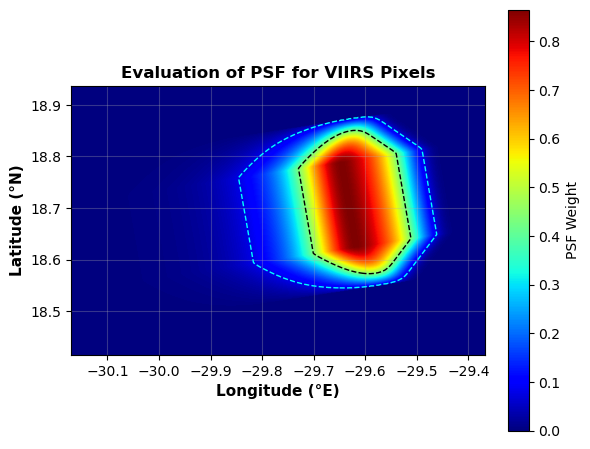

In [ ]:
"""
Plot VIIRS Pixels by PSF Weight
================================
Visualizes the CERES PSF footprint as seen through real VIIRS pixels,
colored by their PSF weight. This is the first cell where the full
pipeline comes together — real VIIRS pixel positions, the ATBD satellite
axis system, and the PSF weights are all combined into a single geographic
view of the footprint.

Unlike the synthetic simulation (which used a uniform angular grid and
a scan azimuth rotation to place the footprint on the ground), the PSF
orientation and shape here emerge directly from the ATBD geometry.
The (δ, β) offsets were computed from actual pixel positions via
Eq 4.4-8, so the PSF tail direction, footprint elongation, and
geographic placement are all physically implemented.

Contour levels match the ATBD Table 4.4-2 thresholds:
  Black → half-power  (PSF evaluated at δ = -0.88°, β = 0°)
  Cyan  → 95%-energy  (PSF evaluated at δ = -1.25°, β = 0°)

"""

def plot_viirs_psf_footprint(df_with_psf, ceres_lat, ceres_lon,
                              min_psf_threshold=1e-8,
                              figsize=(6, 6),
                              use_interpolation=True):
    """
    Plot VIIRS pixels colored by PSF weight.

    Parameters
    ----------
    df_with_psf       : pandas.DataFrame
        Must have: lat, lon, delta_deg, beta_deg, psf_weight
    ceres_lat, ceres_lon : float
        CERES footprint center
    min_psf_threshold : float
        Minimum PSF weight to plot (default 1e-8)
    figsize           : tuple
        Figure size
    use_interpolation : bool
        If True, interpolate smoothly between pixels.
        If False, plot discrete squares (default True).

    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    # Filter to non-NaN and significant PSF weights
    df_plot = df_with_psf.dropna(subset=['delta_deg', 'beta_deg', 'psf_weight'])
    df_plot = df_plot[df_plot['psf_weight'] > min_psf_threshold].copy()

    print("="*80)
    print("VIIRS PSF FOOTPRINT PLOT")
    print("="*80)
    print(f"\nTotal pixels in dataset         : {len(df_with_psf):,}")
    print(f"Pixels with valid (δ, β)        : {len(df_with_psf.dropna(subset=['delta_deg'])):,}")
    print(f"Pixels with PSF > {min_psf_threshold:.0e} : {len(df_plot):,}")

    if len(df_plot) == 0:
        print("\nWARNING: No pixels above threshold!")
        max_psf = df_with_psf['psf_weight'].max()
        print(f"  Max PSF in dataset: {max_psf:.6e}")
        if np.isnan(max_psf):
            print("  PSF values are all NaN — did you compute them?")
        else:
            print(f"  Try lowering min_psf_threshold to {max_psf/100:.2e}")
        return None

    print(f"Max PSF weight  : {df_plot['psf_weight'].max():.6f}")
    print(f"Min PSF (plotted): {df_plot['psf_weight'].min():.6e}")

    # Contour thresholds evaluated at the ATBD Table 4.4-2 back boundary points
    # (-0.88° and -1.25° at β=0). Using the back boundary exclusively avoids
    # the asymmetry issue from averaging front/back PSF evaluations — see note
    # in generate_ceres_footprint().
    half_power = compute_psf_weight(np.array([-0.88]), np.array([0.0]))[0]
    energy_95  = compute_psf_weight(np.array([-1.25]), np.array([0.0]))[0]

    # Axis limits derived from data with a small pad so the footprint
    # isn't clipped at the edge of the plot
    pad = 0.05
    lon_min = df_plot['lon'].min() - pad
    lon_max = df_plot['lon'].max() + pad
    lat_min = df_plot['lat'].min() - pad
    lat_max = df_plot['lat'].max() + pad

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Build a single interpolated grid — reused for both the image and contours
    # to avoid computing griddata twice.
    lon_grid = np.linspace(lon_min, lon_max, 400)
    lat_grid = np.linspace(lat_min, lat_max, 400)
    LON_GRID, LAT_GRID = np.meshgrid(lon_grid, lat_grid)

    points   = df_plot[['lon', 'lat']].values
    values   = df_plot['psf_weight'].values
    PSF_GRID = griddata(points, values, (LON_GRID, LAT_GRID),
                        method='linear', fill_value=0.0)

    if use_interpolation:
        print(f"Creating smooth interpolation of {len(df_plot):,} pixels...")

        im = ax.imshow(PSF_GRID,
                       extent=[lon_grid[0], lon_grid[-1],
                               lat_grid[0], lat_grid[-1]],
                       origin='lower', cmap='jet', vmin=0,
                       vmax=df_plot['psf_weight'].max(),
                       aspect='auto', interpolation='bilinear')

    else:
        # Plot pixels as actual-sized squares using a vectorized PatchCollection.
        # VIIRS M-band resolution is ~750 m at nadir.
        pixel_size_km  = 0.75
        km_per_deg_lat = 111.0
        km_per_deg_lon = 111.0 * np.cos(np.radians(ceres_lat))
        pixel_size_lat = pixel_size_km / km_per_deg_lat
        pixel_size_lon = pixel_size_km / km_per_deg_lon

        print(f"Plotting {len(df_plot):,} pixels as {pixel_size_km} km squares...")
        print(f"  Pixel size: {pixel_size_lat:.6f}° lat × {pixel_size_lon:.6f}° lon")

        # Build rectangles vectorized — avoids slow iterrows() loop
        lons = df_plot['lon'].values
        lats = df_plot['lat'].values
        cols = df_plot['psf_weight'].values

        patches = [
            Rectangle(
                (lons[i] - pixel_size_lon / 2,
                 lats[i] - pixel_size_lat / 2),
                pixel_size_lon,
                pixel_size_lat
            )
            for i in range(len(lons))
        ]

        pc = PatchCollection(patches, cmap='jet', edgecolors='none', alpha=0.9)
        pc.set_array(cols)
        pc.set_clim(0, cols.max())
        ax.add_collection(pc)
        im = pc

        ax.set_facecolor('#00007f')  # Dark blue matches jet colormap at 0

    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

    # Contours drawn from the same PSF_GRID computed above
    try:
        ax.contour(LON_GRID, LAT_GRID, PSF_GRID, levels=[half_power],
                   colors='black', linewidths=1, linestyles='--')
        ax.contour(LON_GRID, LAT_GRID, PSF_GRID, levels=[energy_95],
                   colors='cyan',  linewidths=1, linestyles='--')
    except Exception:
        print("  Warning: Could not draw contours (insufficient data)")

    ax.set_xlabel('Longitude (°E)', fontsize=11, weight='bold')
    ax.set_ylabel('Latitude (°N)',  fontsize=11, weight='bold')
    ax.set_title('Evaluation of PSF for VIIRS Pixels', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax, label='PSF Weight', fraction=0.046)
    plt.tight_layout()

    # Summary
    print(f"\nGeographic extent:")
    print(f"  Lat: [{df_plot['lat'].min():.4f}°, {df_plot['lat'].max():.4f}°]")
    print(f"  Lon: [{df_plot['lon'].min():.4f}°, {df_plot['lon'].max():.4f}°]")

    print(f"\nAngular extent:")
    print(f"  δ: [{df_plot['delta_deg'].min():+.4f}°, {df_plot['delta_deg'].max():+.4f}°]")
    print(f"  β: [{df_plot['beta_deg'].min():+.4f}°, {df_plot['beta_deg'].max():+.4f}°]")

    print(f"\nPSF statistics:")
    max_psf = df_plot['psf_weight'].max()
    for threshold in [0.5, 0.1, 0.01, 0.001]:
        n = (df_plot['psf_weight'] > threshold * max_psf).sum()
        print(f"  Pixels > {threshold*100:.1f}% max: {n:,}")

    print("="*80 + "\n")

    return fig


# ==============================================================================
# EXECUTE
# ==============================================================================

# Compute PSF weight for every VIIRS pixel using its (δ, β) offset
df_m_with_angles['psf_weight'] = compute_psf_weight(
    df_m_with_angles['delta_deg'].values,
    df_m_with_angles['beta_deg'].values
)

### FOR I BANDS: 
# df_i_with_angles['psf_weight'] = compute_psf_weight(
#     df_i_with_angles['delta_deg'].values,
#     df_i_with_angles['beta_deg'].values
# )


fig = plot_viirs_psf_footprint(
    df_m_with_angles,
    ceres_lat=18.7054,
    ceres_lon=-29.6446,
    min_psf_threshold=1e-8,
    use_interpolation=True
)
plt.show()

### FOR I BANDS:
# fig = plot_viirs_psf_footprint(
#     df_i_with_angles,
#     ceres_lat=18.7054,
#     ceres_lon=-29.6446,
#     min_psf_threshold=1e-8,
#     use_interpolation=True
# )
# plt.show()

M-band grid: (51, 51) bins, 95% mask achieved = 0.9501


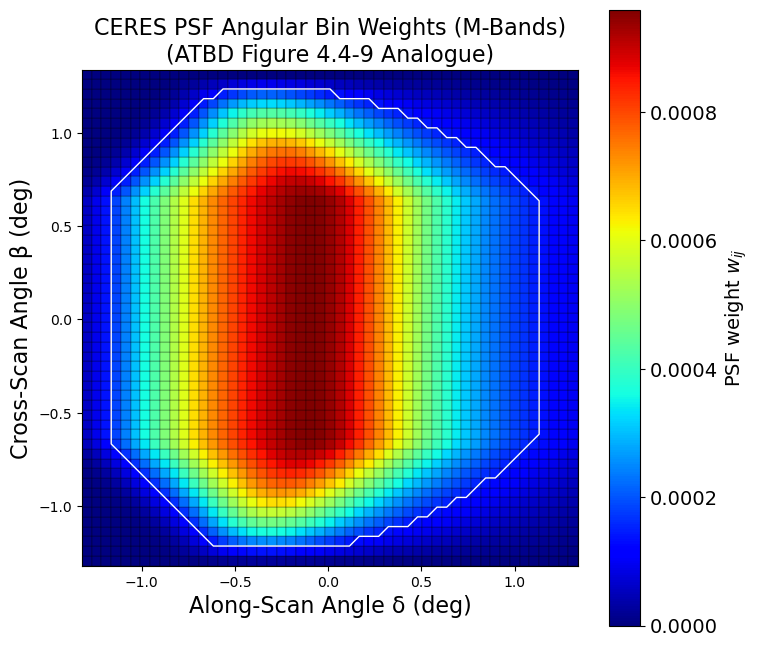

Band M10
  Mean radiance : 0.565245
  Std dev       : 0.027875
  Coverage      : 96.0%
  Accepted      : True

Band M12
  Mean radiance : 0.372045
  Std dev       : 0.001330
  Coverage      : 96.0%
  Accepted      : True

Band M3
  Mean radiance : 42.516406
  Std dev       : 0.314222
  Coverage      : 96.0%
  Accepted      : True

Band M4
  Mean radiance : 24.139286
  Std dev       : 0.203120
  Coverage      : 96.0%
  Accepted      : True

Band M7
  Mean radiance : 4.191024
  Std dev       : 0.113183
  Coverage      : 96.0%
  Accepted      : True

Band M8
  Mean radiance : 1.256445
  Std dev       : 0.057935
  Coverage      : 96.0%
  Accepted      : True



In [15]:
def create_angular_grid_snpp(
    satellite_altitude_km=824.0,
    imager_resolution_km=0.75
):
    """
    ATBD 2.2 §4.4.2.6 angular grid definition.

    Grid step size is derived from the VIIRS M-band pixel size projected
    to an angular resolution at the satellite altitude. The FOV extent
    is set to 1.32° — the 95%-energy boundary from ATBD Figure 4.4-9 —
    giving a grid that spans the full meaningful PSF support.

    This is a one-time setup call. The returned edges are passed to
    compute_psf_weights() and reused for all subsequent integration.
    """

    # Angular step matching VIIRS M-band pixel size at satellite altitude
    delta_step = np.degrees(np.arctan(imager_resolution_km / satellite_altitude_km))
    beta_step  = delta_step

    # 1.32° = 95%-energy boundary per ATBD §4.4.2.6 / Figure 4.4-9
    FOV_EXTENT_DEG = 1.32

    delta_edges = np.arange(-FOV_EXTENT_DEG, FOV_EXTENT_DEG + delta_step, delta_step)
    beta_edges  = np.arange(-FOV_EXTENT_DEG, FOV_EXTENT_DEG + beta_step,  beta_step)

    return {
        "delta_edges": delta_edges,
        "beta_edges":  beta_edges,
        "delta_step":  delta_step,
        "beta_step":   beta_step,
    }


def compute_psf_weights(delta_edges, beta_edges, psf_function):
    """
    Numerically integrate the PSF over each angular bin:

        w_ij = ∬ P(δ,β) cos(β) dδ dβ

    Uses scipy.integrate.dblquad for accuracy. This is a slow one-time
    precomputation — cache the result and do not recompute per footprint.

    Weights are normalized to sum to unity after integration, consistent
    with the ATBD probability-mass convention.
    """

    n_delta = len(delta_edges) - 1
    n_beta  = len(beta_edges)  - 1

    weights = np.zeros((n_beta, n_delta))

    for i in range(n_delta):
        for j in range(n_beta):

            δ0, δ1 = delta_edges[i], delta_edges[i + 1]
            β0, β1 = beta_edges[j],  beta_edges[j + 1]

            def integrand(β, δ):
                return psf_function(np.array([δ]), np.array([β]))[0] * np.cos(np.radians(β))

            w, _ = integrate.dblquad(
                integrand,
                δ0, δ1,
                lambda _: β0,
                lambda _: β1
            )

            weights[j, i] = w

    # Normalize to unity — defensive, ATBD-consistent
    weights /= weights.sum()

    return weights


def compute_psf_95_mask(weights_2d, target_fraction=0.95):
    """
    Find the smallest set of bins enclosing target_fraction of PSF energy.

    Bins are selected in descending weight order until the cumulative sum
    reaches target_fraction. Note: this produces the highest-weight bins
    regardless of spatial contiguity. For the CERES PSF this is not an
    issue in practice since the PSF is unimodal and the 95% support is a
    single connected region.
    """

    flat  = weights_2d.ravel()
    order = np.argsort(flat)[::-1]

    cumsum  = np.cumsum(flat[order])
    cutoff  = np.searchsorted(cumsum, target_fraction)

    mask_flat = np.zeros_like(flat, dtype=bool)
    mask_flat[order[:cutoff + 1]] = True

    mask     = mask_flat.reshape(weights_2d.shape)
    achieved = weights_2d[mask].sum()

    return mask, achieved


def integrate_radiance_over_fov_by_band(
    df,
    delta_edges,
    beta_edges,
    weights_2d,
    psf_mask_95,
    radiance_column="radiance",
    band_column="band",
    min_coverage_fraction=0.75
):
    """
    Compute PSF-weighted mean radiance per band over the CERES FOV.

    For each band, VIIRS pixels are assigned to angular bins via their
    (δ, β) offsets. Only bins inside the 95%-energy PSF support mask
    are used. Bins with multiple pixels are averaged before weighting.

    Bands that fail the min_coverage_fraction threshold are flagged as
    rejected and a warning is printed — check coverage before using results.
    """

    results = {}

    n_delta = len(delta_edges) - 1
    n_beta  = len(beta_edges)  - 1

    for band, df_band in df.groupby(band_column):

        df_valid = df_band.dropna(
            subset=["delta_deg", "beta_deg", radiance_column]
        ).copy()

        if df_valid.empty:
            results[band] = {
                "weighted_mean":     np.nan,
                "weighted_std":      np.nan,
                "coverage_fraction": 0.0,
                "accepted":          False,
                "bin_means":         np.full((n_beta, n_delta), np.nan)
            }
            print(f"  WARNING: Band {band} — no valid pixels")
            continue

        # Assign each pixel to a bin — vectorized with np.digitize
        # clip ensures out-of-range pixels map to the first/last bin index
        i_bins = np.clip(
            np.digitize(df_valid["delta_deg"].values, delta_edges) - 1,
            0, n_delta - 1
        )
        j_bins = np.clip(
            np.digitize(df_valid["beta_deg"].values, beta_edges) - 1,
            0, n_beta - 1
        )

        # Flat bin indices for accumulation
        flat_idx = j_bins * n_delta + i_bins
        n_bins   = n_delta * n_beta
        rad_vals = df_valid[radiance_column].values

        # Sum and count per bin using np.bincount — fast vectorized accumulation
        bin_sum   = np.bincount(flat_idx, weights=rad_vals,          minlength=n_bins)
        bin_count = np.bincount(flat_idx,                            minlength=n_bins).astype(int)

        bin_sum   = bin_sum.reshape(n_beta, n_delta)
        bin_count = bin_count.reshape(n_beta, n_delta)

        bin_mean  = np.full((n_beta, n_delta), np.nan)
        populated = bin_count > 0
        bin_mean[populated] = bin_sum[populated] / bin_count[populated]

        # Coverage: fraction of 95%-mask weight covered by populated bins
        covered_weight = weights_2d[psf_mask_95 & populated].sum()
        total_weight   = weights_2d[psf_mask_95].sum()
        coverage       = covered_weight / total_weight if total_weight > 0 else 0.0

        # PSF-weighted mean and std over valid bins inside 95% mask
        valid = psf_mask_95 & populated
        denom = weights_2d[valid].sum()

        if denom > 0:
            mean   = (weights_2d[valid] * bin_mean[valid]).sum() / denom
            second = (weights_2d[valid] * bin_mean[valid] ** 2).sum() / denom
            std    = np.sqrt(max(second - mean ** 2, 0.0))  # clamp rounding negatives
        else:
            mean = np.nan
            std  = np.nan

        accepted = coverage >= min_coverage_fraction

        if not accepted:
            print(f"  WARNING: Band {band} rejected — coverage "
                  f"{coverage*100:.1f}% < {min_coverage_fraction*100:.1f}% threshold")

        results[band] = {
            "weighted_mean":     mean,
            "weighted_std":      std,
            "coverage_fraction": coverage,
            "accepted":          accepted,
            "bin_means":         bin_mean
        }

    return results


def print_integration_summary(result, band):
    print("=" * 60)
    print(f"Band {band}")
    print("=" * 60)
    print(f"  Mean radiance : {result['weighted_mean']:.6f}")
    print(f"  Std dev       : {result['weighted_std']:.6f}")
    print(f"  Coverage      : {result['coverage_fraction']*100:.1f}%")
    print(f"  Accepted      : {result['accepted']}")
    print()


def plot_psf_weights(weights_2d, psf_mask_95, delta_edges, beta_edges):
    """
    Plot PSF bin weights and the 95%-energy support boundary.
    """

    fig, ax = plt.subplots(figsize=(8, 8))

    # Build patch collection vectorized — avoids nested Python loops
    n_beta, n_delta = weights_2d.shape
    j_idx, i_idx   = np.meshgrid(np.arange(n_beta), np.arange(n_delta), indexing='ij')
    j_flat = j_idx.ravel()
    i_flat = i_idx.ravel()

    patches = [
        Rectangle(
            (delta_edges[i], beta_edges[j]),
            delta_edges[i + 1] - delta_edges[i],
            beta_edges[j + 1]  - beta_edges[j]
        )
        for i, j in zip(i_flat, j_flat)
    ]

    pc = PatchCollection(patches, cmap="jet", edgecolor="black", linewidth=0.2)
    pc.set_array(weights_2d.ravel())
    ax.add_collection(pc)

    # 95% PSF support boundary
    ax.contour(
        psf_mask_95.astype(int),
        levels=[0.5],
        colors="white",
        linewidths=1,
        extent=[
            delta_edges[0], delta_edges[-1],
            beta_edges[0],  beta_edges[-1]
        ],
        origin="lower"
    )

    ax.set_xlim(delta_edges[0],  delta_edges[-1])
    ax.set_ylim(beta_edges[0],   beta_edges[-1])
    ax.set_aspect("equal")
    ax.set_xlabel("Along-Scan Angle δ (deg)", fontsize=16)
    ax.set_ylabel("Cross-Scan Angle β (deg)", fontsize=16)
    ax.set_title(
        "CERES PSF Angular Bin Weights (M-Bands)\n"
        "(ATBD Figure 4.4-9 Analogue)",
        fontsize=16
    )

    cbar = plt.colorbar(pc, ax=ax)
    cbar.set_label("PSF weight $w_{ij}$", fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    plt.show()


# ==============================================================================
# EXECUTE
# ==============================================================================

# M-bands: VIIRS M-band resolution ~750 m at nadir
grid_m = create_angular_grid_snpp(
    satellite_altitude_km=824.0,
    imager_resolution_km=0.75
)
weights_m = compute_psf_weights(
    grid_m['delta_edges'], grid_m['beta_edges'], compute_psf_weight
)
mask_m, achieved_m = compute_psf_95_mask(weights_m)
print(f"M-band grid: {weights_m.shape} bins, "
      f"95% mask achieved = {achieved_m:.4f}")

plot_psf_weights(weights_m, mask_m, grid_m['delta_edges'], grid_m['beta_edges'])

results_m = integrate_radiance_over_fov_by_band(
    df_m_with_angles,
    grid_m['delta_edges'], grid_m['beta_edges'],
    weights_m, mask_m
)
for band, result in results_m.items():
    print_integration_summary(result, band)

# I-bands: VIIRS I-band resolution ~375 m at nadir
# grid_i = create_angular_grid_snpp(
#     satellite_altitude_km=824.0,
#     imager_resolution_km=0.375
# )
# weights_i = compute_psf_weights(
#     grid_i['delta_edges'], grid_i['beta_edges'], compute_psf_weight
# )
# mask_i, achieved_i = compute_psf_95_mask(weights_i)
# print(f"I-band grid: {weights_i.shape} bins, "
#       f"95% mask achieved = {achieved_i:.4f}")
# plot_psf_weights(weights_i, mask_i, grid_i['delta_edges'], grid_i['beta_edges'])
# results_i = integrate_radiance_over_fov_by_band(
#     df_i_with_angles,
#     grid_i['delta_edges'], grid_i['beta_edges'],
#     weights_i, mask_i
# )
# for band, result in results_i.items():
#     print_integration_summary(result, band)

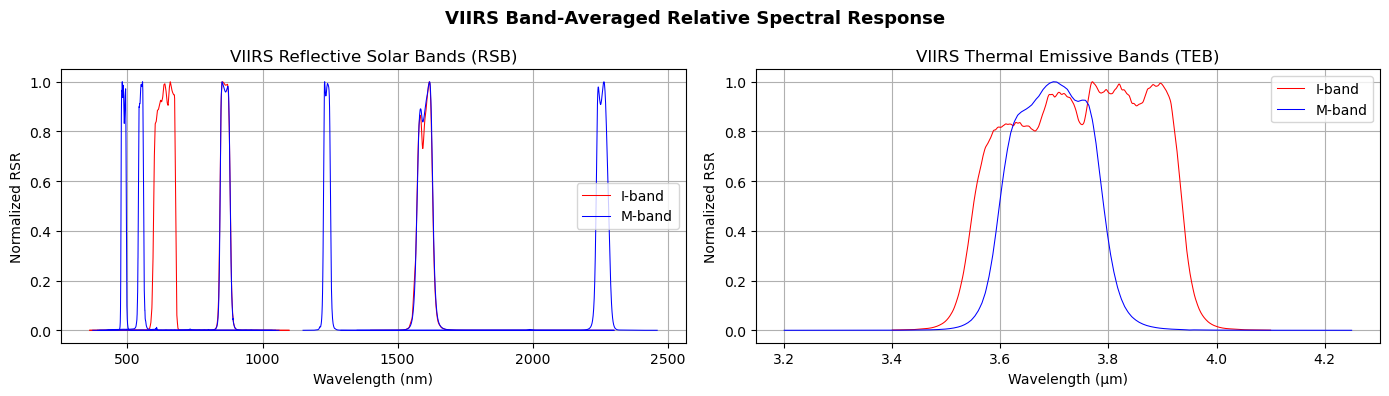


Effective bandwidths Δλ_eff = ∫ RSR(λ) dλ
Used to convert spectral radiance (W/m²/sr/µm) → band radiance (W/m²/sr)
----------------------------------------
   I1: 0.077525 µm
   I2: 0.039395 µm
   I3: 0.057210 µm
   I4: 0.359559 µm
   M3: 0.019010 µm
   M4: 0.020901 µm
   M7: 0.038702 µm
   M8: 0.027121 µm
  M10: 0.058750 µm
  M11: 0.046697 µm
  M12: 0.192217 µm


In [ ]:
"""
VIIRS Relative Spectral Response and Effective Bandwidths
==========================================================
Loads band-averaged RSR files for each VIIRS band used in this study,
computes the effective bandwidth Δλ_eff = ∫ RSR(λ) dλ for each, and
plots all bands in a single RSB and TEB figure.

Effective bandwidths are used downstream to convert PSF-weighted VIIRS
spectral radiances (W/m²/sr/µm) to band-integrated radiances (W/m²/sr)
for comparison with MODTRAN output and CERES broadband fluxes.

VIIRS Band-Averaged Relative Spectral Response Functions can be found at
https://ncc.nesdis.noaa.gov/VIIRS/VIIRSSpectralResponseFunctions.php
"""

FOLDER = "/Users/mcha4384/Desktop/NG_VIIRS_NPP_RSR_filtered_Oct2011_BA/"

# Band name → filename mapping for bands used in this study
BAND_FILES = {
    'I1':  'NPP_VIIRS_NG_RSR_I1_Effective_Oct2011f_BA.dat',
    'I2':  'NPP_VIIRS_NG_RSR_I2_Effective_Oct2011f_BA.dat',
    'I3':  'NPP_VIIRS_NG_RSR_I3_filtered_Oct2011f_BA_Mod.dat',
    'I4':  'NPP_VIIRS_NG_RSR_I4_filtered_Oct2011f_BA.dat',
    'M3':  'NPP_VIIRS_NG_RSR_M3_Fused_Oct2011f_BA.dat',
    'M4':  'NPP_VIIRS_NG_RSR_M4_Fused_Oct2011f_BA.dat',
    'M7':  'NPP_VIIRS_NG_RSR_M7_Fused_Oct2011f_BA.dat',
    'M8':  'NPP_VIIRS_NG_RSR_M8_filtered_Oct2011f_BA.dat',
    'M10': 'NPP_VIIRS_NG_RSR_M10_filtered_Oct2011f_BA.dat',
    'M11': 'NPP_VIIRS_NG_RSR_M11_filtered_Oct2011f_BA.dat',
    'M12': 'NPP_VIIRS_NG_RSR_M12_filtered_Oct2011f_BA.dat',
}

# RSB and TEB groupings for plotting
RSB_BANDS = ['I1', 'I2', 'I3', 'M3', 'M4', 'M7', 'M8', 'M10', 'M11']
TEB_BANDS = ['I4', 'M12']

# ============================================================================
# LOAD RSR DATA AND COMPUTE EFFECTIVE BANDWIDTHS
# ============================================================================

rsr_data   = {}   # band → {'wavelength_nm': ..., 'rsr': ...}
bandwidths = {}   # band → Δλ_eff in µm

for band, fname in BAND_FILES.items():
    data = np.loadtxt(os.path.join(FOLDER, fname))
    wavelength_nm = data[:, 0]
    rsr           = data[:, 1]

    rsr_data[band] = {'wavelength_nm': wavelength_nm, 'rsr': rsr}

    # Δλ_eff = ∫ RSR(λ) dλ  (trapz in nm, converted to µm)
    bandwidths[band] = np.trapz(rsr, wavelength_nm) / 1000.0

# ============================================================================
# PLOT — RSB (reflective solar bands, wavelength in nm)
# ============================================================================

colors = {'M': 'blue', 'I': 'red'}

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
added = {'M': False, 'I': False}
for band in RSB_BANDS:
    d = rsr_data[band]
    btype = band[0]
    label = f'{btype}-band' if not added[btype] else None
    added[btype] = True
    ax.plot(d['wavelength_nm'], d['rsr'],
            color=colors[btype], linewidth=0.75, label=label)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Normalized RSR')
ax.set_title('VIIRS Reflective Solar Bands (RSB)')
ax.grid(True)
ax.legend()

# ============================================================================
# PLOT — TEB (thermal emissive bands, wavelength in µm)
# ============================================================================

ax = axes[1]
added = {'M': False, 'I': False}
for band in TEB_BANDS:
    d = rsr_data[band]
    btype = band[0]
    label = f'{btype}-band' if not added[btype] else None
    added[btype] = True
    ax.plot(d['wavelength_nm'] / 1000.0, d['rsr'],
            color=colors[btype], linewidth=0.75, label=label)
ax.set_xlabel('Wavelength (µm)')
ax.set_ylabel('Normalized RSR')
ax.set_title('VIIRS Thermal Emissive Bands (TEB)')
ax.grid(True)
ax.legend()

plt.suptitle('VIIRS Band-Averaged Relative Spectral Response', fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# EFFECTIVE BANDWIDTHS
# ============================================================================

print("\nEffective bandwidths Δλ_eff = ∫ RSR(λ) dλ")
print("Used to convert spectral radiance (W/m²/sr/µm) → band radiance (W/m²/sr)")
print("-" * 40)
for band, bw in bandwidths.items():
    print(f"  {band:>3}: {bw:.6f} µm")

In [21]:
# ==============================================================================
# CONVERT SPECTRAL RADIANCE → BAND-INTEGRATED RADIANCE
# Multiply PSF-weighted mean spectral radiance (W/m²/sr/µm) by effective
# bandwidth (µm) to get band-integrated radiance (W/m²/sr).
# ==============================================================================

print("M Band-integrated radiances (W/m²/sr)")
print("-" * 40)
for band, result in results_m.items():
    if result['accepted'] and not np.isnan(result['weighted_mean']):
        L_band = result['weighted_mean'] * bandwidths[band]
        print(f"  {band:>3}: {result['weighted_mean']:.6f} W/m²/sr/µm  ×  "
              f"{bandwidths[band]:.6f} µm  =  {L_band:.6f} W/m²/sr")
    else:
        print(f"  {band:>3}: rejected or no data (coverage = "
              f"{result['coverage_fraction']*100:.1f}%)")



# print("I Band-integrated radiances (W/m²/sr)")
# print("-" * 40)
# for band, result in results_i.items():
#     if result['accepted'] and not np.isnan(result['weighted_mean']):
#         L_band = result['weighted_mean'] * bandwidths[band]
#         print(f"  {band:>3}: {result['weighted_mean']:.6f} W/m²/sr/µm  ×  "
#               f"{bandwidths[band]:.6f} µm  =  {L_band:.6f} W/m²/sr")
#     else:
#         print(f"  {band:>3}: rejected or no data (coverage = "
#               f"{result['coverage_fraction']*100:.1f}%)")

M Band-integrated radiances (W/m²/sr)
----------------------------------------
  M10: 0.565245 W/m²/sr/µm  ×  0.058750 µm  =  0.033208 W/m²/sr
  M12: 0.372045 W/m²/sr/µm  ×  0.192217 µm  =  0.071513 W/m²/sr
   M3: 42.516406 W/m²/sr/µm  ×  0.019010 µm  =  0.808235 W/m²/sr
   M4: 24.139286 W/m²/sr/µm  ×  0.020901 µm  =  0.504526 W/m²/sr
   M7: 4.191024 W/m²/sr/µm  ×  0.038702 µm  =  0.162203 W/m²/sr
   M8: 1.256445 W/m²/sr/µm  ×  0.027121 µm  =  0.034076 W/m²/sr
